In [1]:
from template_funciones import *
from template_funciones_2 import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

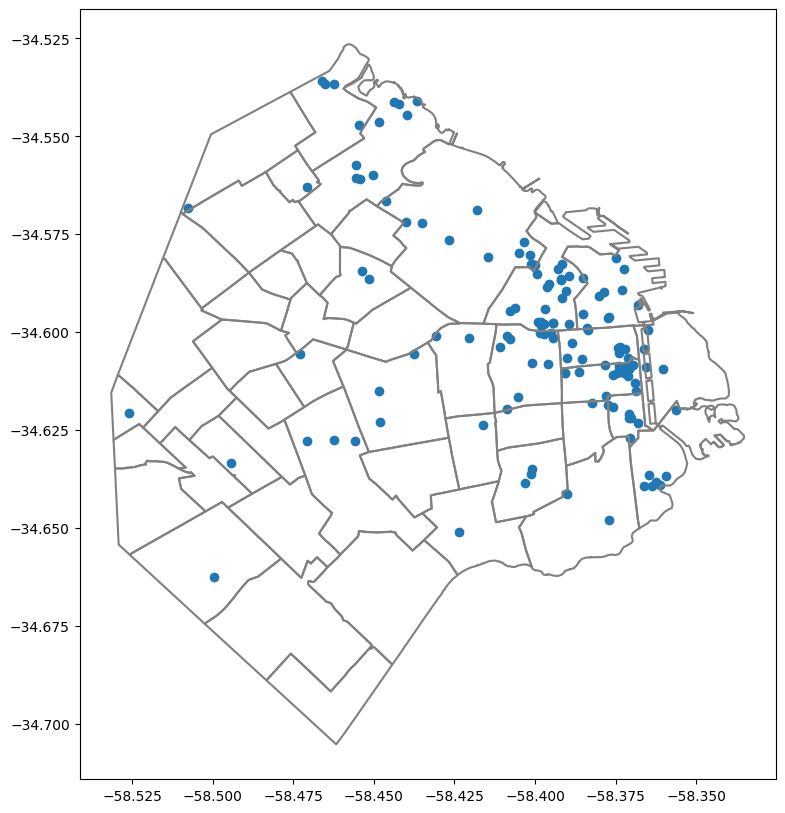

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

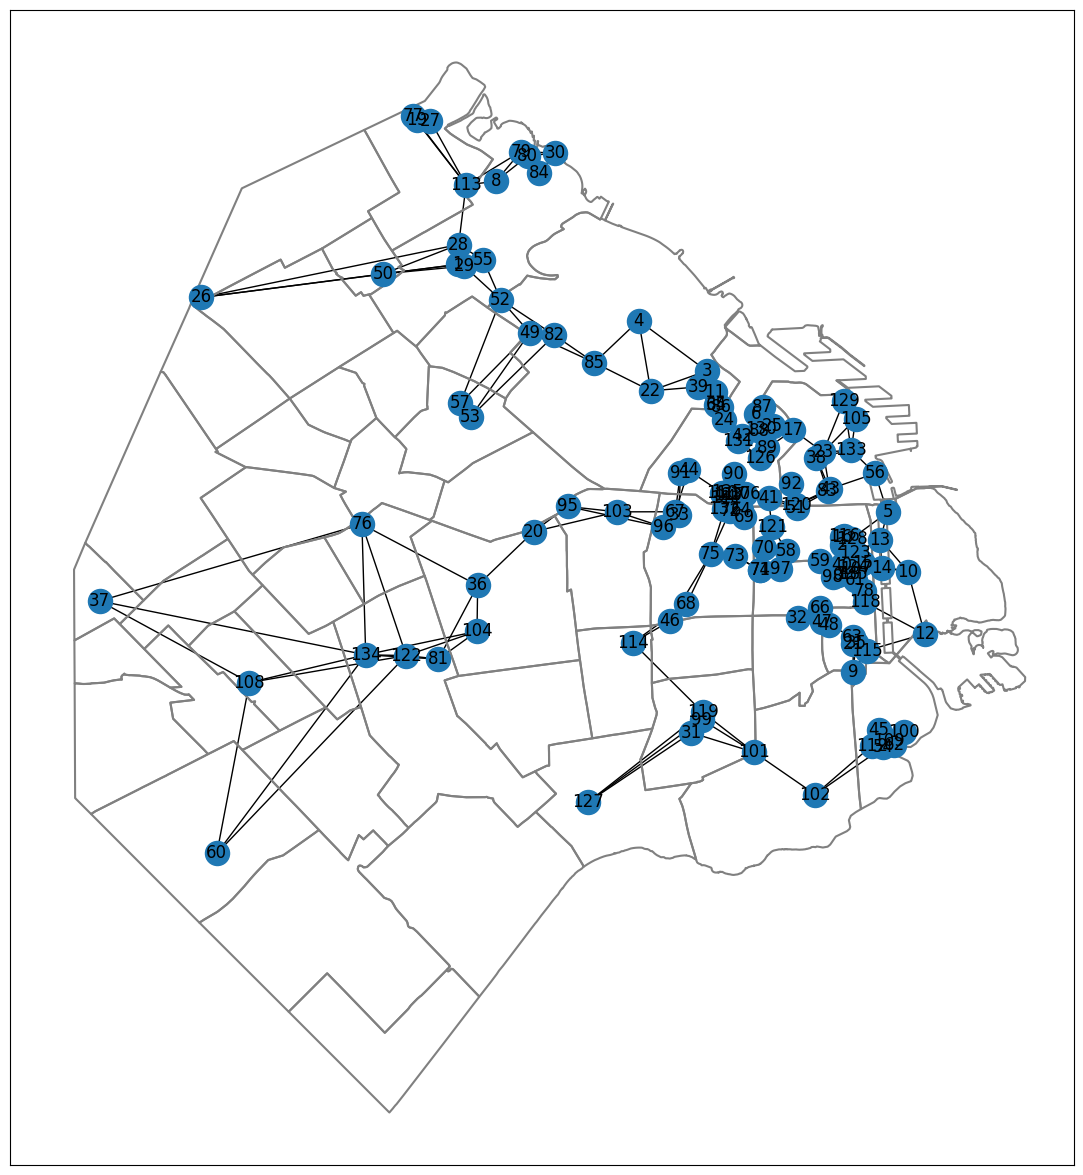

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Queremos mostrar que el vector de rankings $\textbf{p}$ es solución de la ecuación $M\textbf{p} = \textbf{b}$ con $M = \frac{N}{\alpha}(I - (1 - \alpha)C)$ y $b = \textbf{1}$, es decir el vector compuesto por 1's.
Partiendo de la ecuación:
\begin{equation}
  p = (1 - \alpha)Cp + \frac{\alpha}{N} \textbf{1}
\end{equation}
Sabemos que podemos reescribirla de la siguiente manera:

\begin{align*}
     \Rightarrow p - (1 - \alpha)Cp = \frac{\alpha}{N} \textbf{1} \\ \iff  
     (I - (1 - \alpha)C)p = \frac{\alpha}{N}\textbf{1} \\ \iff
     \frac{N}{\alpha} (I - (1 - \alpha)C)p = \textbf{1}
\end{align*}
Recordando la definición de M y b podemos notar que la ultima equivalencia es exactamente $M\textbf{p} = \textbf{b}$. Luego podemos decir que el vector rankings es solución de la ecuación $M\textbf{p} = \textbf{b}$


## Punto 2:


La condición que debe cumplir la ecuación del punto anterior es que la matriz sea inversible. Queremos que el sistema tenga una unica solucion y por tanto debe ser un sistema compatible determinado (SCD). 

Para poder afirmar que se cumple para la matriz construida para los museos, basta con ver que $I - (1 - \alpha)C$ tenga inversa.

Sabemos que C es una matriz estocática, es decir, la suma de cada columna suma 1. Por tanto $||C||_1 = 1$

Llamemos B a $(1 - \alpha)C$.
Recordando las propiedades de la norma matricial podemos afirmar que:
$||B||_1 = |(1 - \alpha)| \cdot ||C||_1 \iff ||B||_1 = |1 - \alpha| \cdot 1 \iff ||B||_1 = |1-\alpha|$  y como $\alpha \in (0,1) \Rightarrow ||B||_1 < 1$

Supongamos ahora que I-B no tiene inversa $\Rightarrow \exists v \neq 0: (I-B)v = 0 \Rightarrow Bv = v$

También, por definición de la norma sabemos que $\forall x \neq 0$ vale que:
$\frac{||Bx||}{||x||} \leq ||B|| < 1 \Rightarrow ||Bx|| < ||x||$

Como $v \neq 0$ tambien vemos que: $||Bv||< ||v|| \iff ||v|| < ||v||$ es absurdo.

Luego, podemos afirmar que como $(I-B)$ tiene inversa entonces M tiene inversa y por tanto queda probado que M tiene solución única, como inicialmente queriamos ver.

## Punto 3:

Construimos la red con la ayuda de la libreria networkx, además de hacer uso de las funciones del template ya completadas (en este caso calcula_pagerank y construye_adyacencia). Creamos una función propia graficar_grafo que toma como entradas D (nuestra matriz original), un m dado (usaremos el que se nos pide en la consigna), un $\alpha$ (al igual que para el m, usaremos el que se nos pide en la consigna) y tambien le pasamos los barrios, los Nprincipales y el layout del grafo (G_layout).



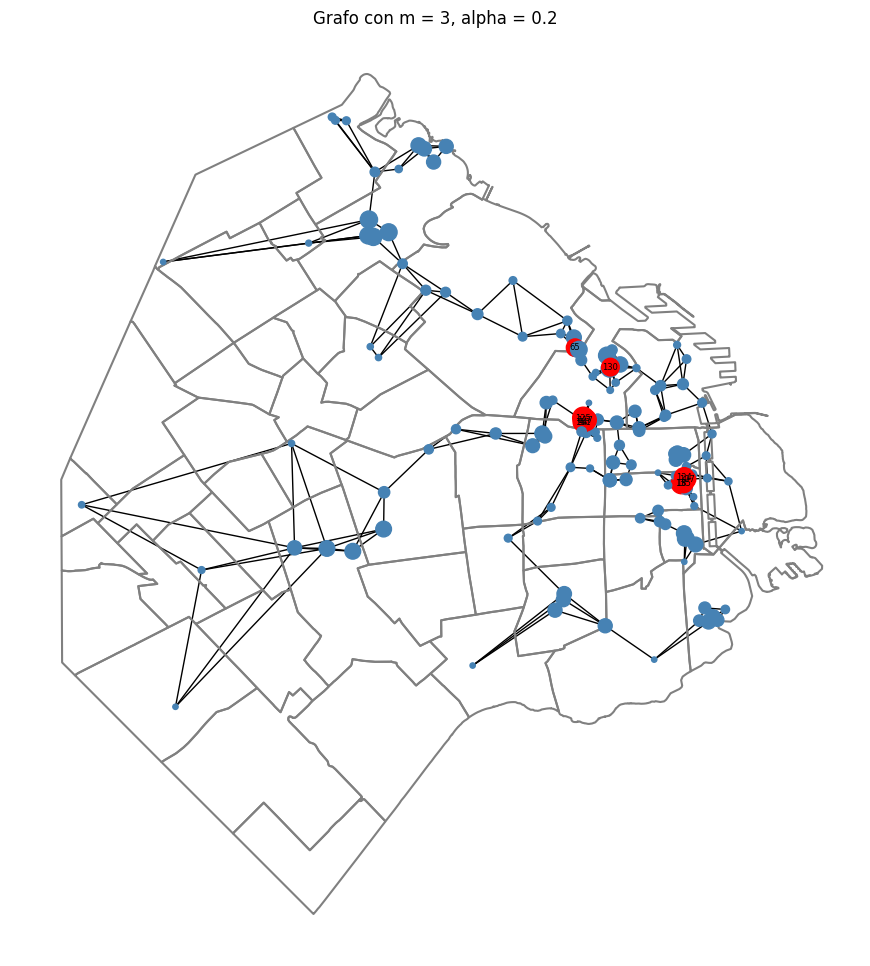

In [8]:
# Llamamos la función ubicada en el template graficar_grafo con m = 3 y alpha = 1/5 como se nos pide en el punto a)
graficar_grafo(D, 3, 1/5, barrios, 10, G_layout)

Los mejores museos que tuvimos entonces fueron:

In [9]:
A = construye_adyacencia(D, 3)
alfa = 1/5
pr = calcula_pagerank(A,alfa)

nPrincipales = 5
principales = np.argsort(pr)[-nPrincipales:]

museos.iloc[principales]['name']

135                                    Museo Franciscano
111    Museo Houssay de Historia de la Ciencia y la T...
18                                    Museo de la Ciudad
125                  Museo de la Facultad de Odontología
117                             Museo de Farmacobotánica
Name: name, dtype: object

b) Ahora vemos los casos m=1,3,5,10 con $\alpha = 1/5$. El caso con m = 3 ya lo vimos, a pesar de eso, lo tendremos en cuenta. Llamamos la funcion calcular_pagerank para esos valores con la matriz D ayudandonos de la funcion calcular_ps, que como su nombre lo indica, calcula los pageRanks de la matriz de adyacencia A armada a partir de D, el m y $\alpha$ correspondiente. Además creamos una función llamada tabla_valores_p que nos dará, justamente, una tabla de los valores de p para los distintos m, y luego (punto c de este ejercicio) nos lo hará para distintos alphas. Aqui le pasamos como parametro fijo al $\alpha$.

In [10]:
# Para este ejercicio, llamamos la funcion creada para mostrar los valores de p con los distintos m pedidos, que estan dentro de la lista lista_m
lista_m = [1, 3, 5, 10]
df_p_m = tabla_valores_p(D,lista_m, nombre_parametro='m', fijo=1/5)


 Valores del vector p según variación de m (con el otro parámetro fijo en 0.2):


Veamoslo en el mapa:

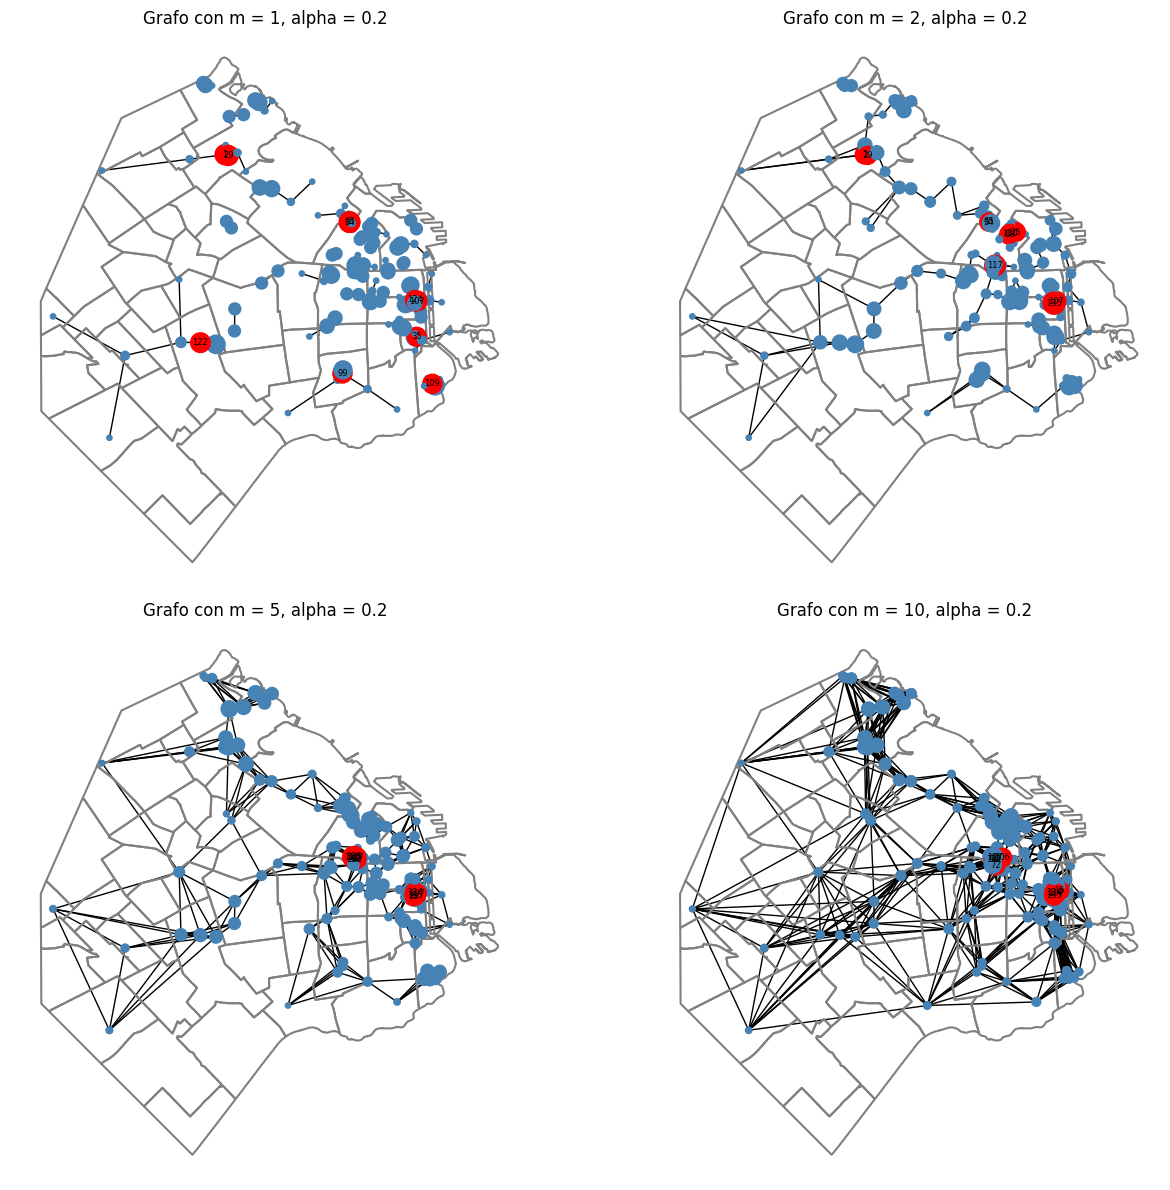

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,12))
axs = axs.flatten()
for j, i in enumerate([1,2,5,10]):
    graficar_grafo(D, i, 0.2, barrios, 10, G_layout, ax=axs[j])

for k in range(len([1,2,5,10]), len(axs)):
    axs[k].axis("off")
plt.tight_layout()
plt.show()   

c) Ahora se nos pide hacer algo similar al punto anterior, solo que variando el $\alpha$. En este caso queremos ver que sucede con el vector p para m = 5 y $\alpha = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$. Al igual que para el punto b), nos aprovecharemos de codigo que nos devuelve la tabla de valores con cada p para cada $\alpha$ con m fijo en 5.


In [12]:
# Hacemos lo mismo que para el punto b) pero con lo pedido en el c)
lista_alpha = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
df_p_alpha = tabla_valores_p(D,lista_alpha, nombre_parametro='alpha', fijo=5)


 Valores del vector p según variación de alpha (con el otro parámetro fijo en 5):


Veamos esta variación en el mapa:

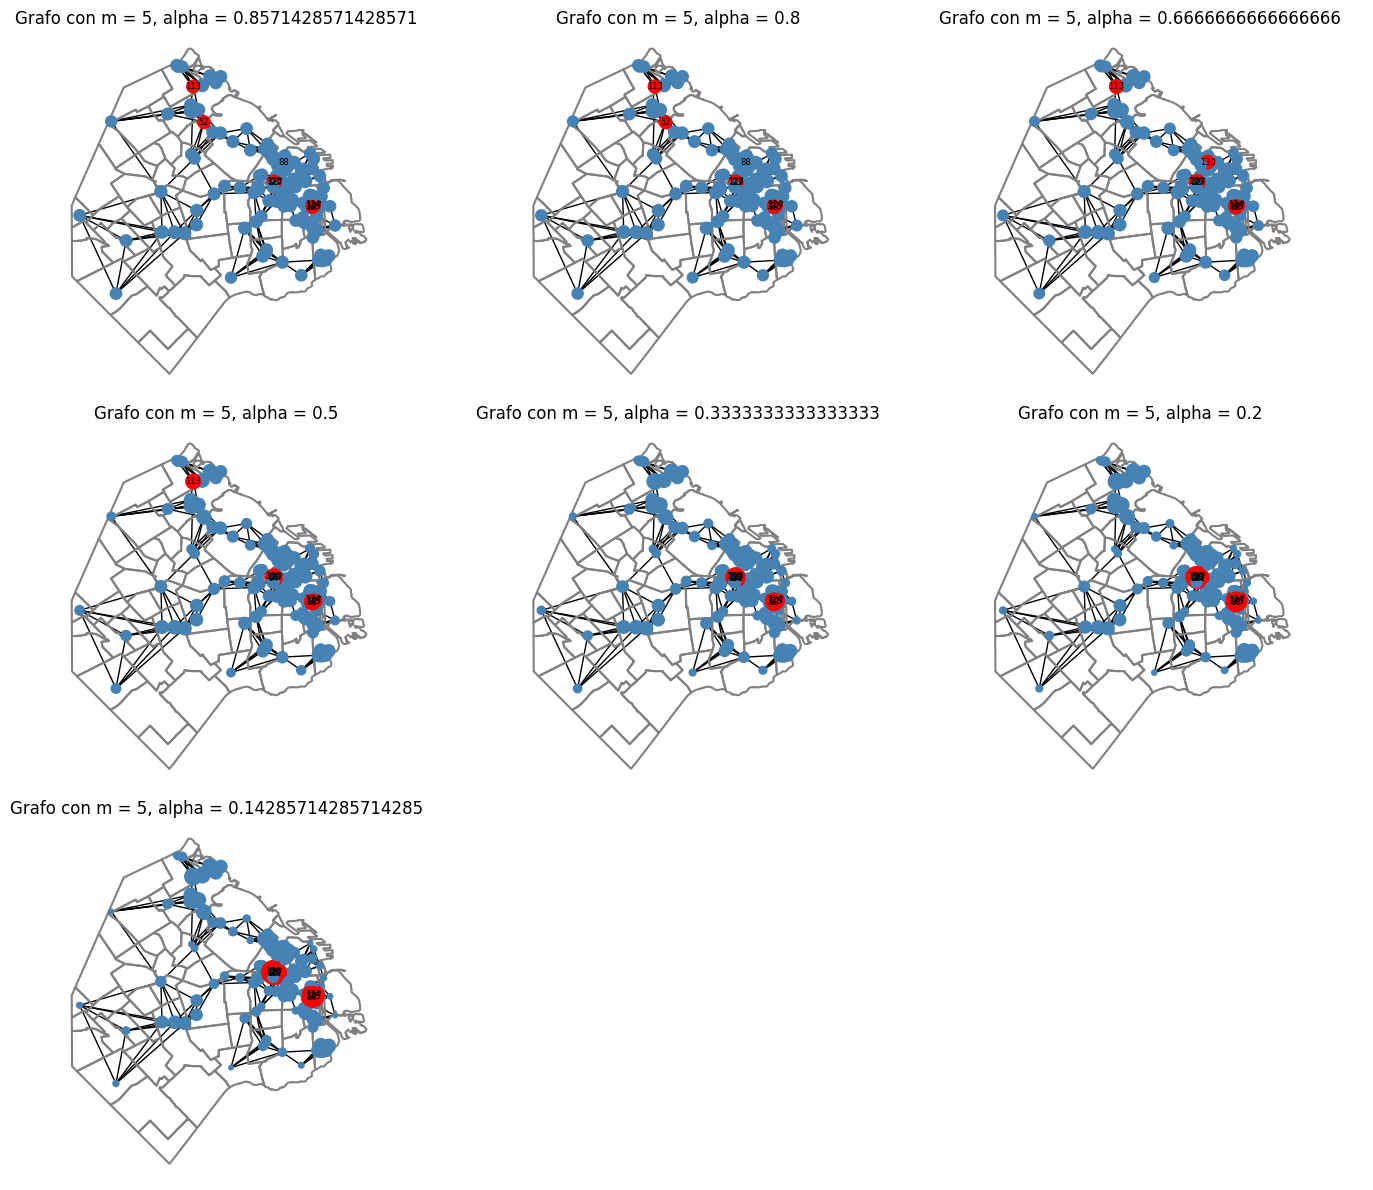

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(14,12))
axs = axs.flatten()
for j, i in enumerate(lista_alpha):
    graficar_grafo(D, 5, i, barrios, 10, G_layout, ax=axs[j])

for k in range(len(lista_alpha), len(axs)):
    axs[k].axis("off")
plt.tight_layout()
plt.show()

### Segunda parte

Para esta segunda parte del ejercicio guardamos en dos listas los valores de p pedidos tanto para el punto b) como el c). Como en el b variamos la variable m y dejamos fijo el $\alpha$ la llamamos variando_m y a la del c), variando_alpha. La informacion fue guardada en tuplas (p, alpha) o (p, m) dependiendo de si es en variando_alpha o variando_m respectivamente. Ahora queremos ver los 3 museos más vistos para cada p de todos los evaluados. Para eso queremos ver los 3 valores maximos de cada vector p. Tomamos como museos más centrales a los más visitados, es decir, con un mayor pageRank. Los devolveremos en una tabla para una mayor facilidad de lectura ayudados por la función tabla_top3_variando_v (ver template de funciones):

In [14]:
variando_m = []
variando_alpha = []

for m in lista_m:
  p = calcular_ps(D,1/5, m)
  variando_m.append((p,m)) # Guardamos cada p obtenido con su m que varió correspondiente

for alpha in lista_alpha:
  p = calcular_ps(D,alpha, 5)
  variando_alpha.append((p, alpha)) # Guardamos cada p calculado con su alpha que varió correspondiente

In [15]:
df_top3_alpha = tabla_top3_variando_v(variando_alpha, "alpha")
df_top3_m = tabla_top3_variando_v(variando_m, "m")


 Top 3 nodos según alpha: 




 Top 3 nodos según m: 



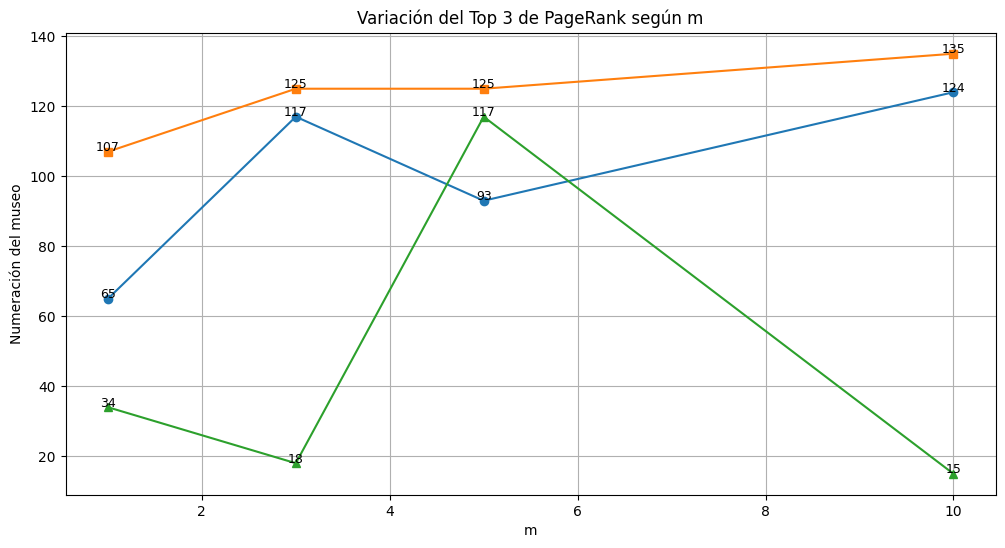

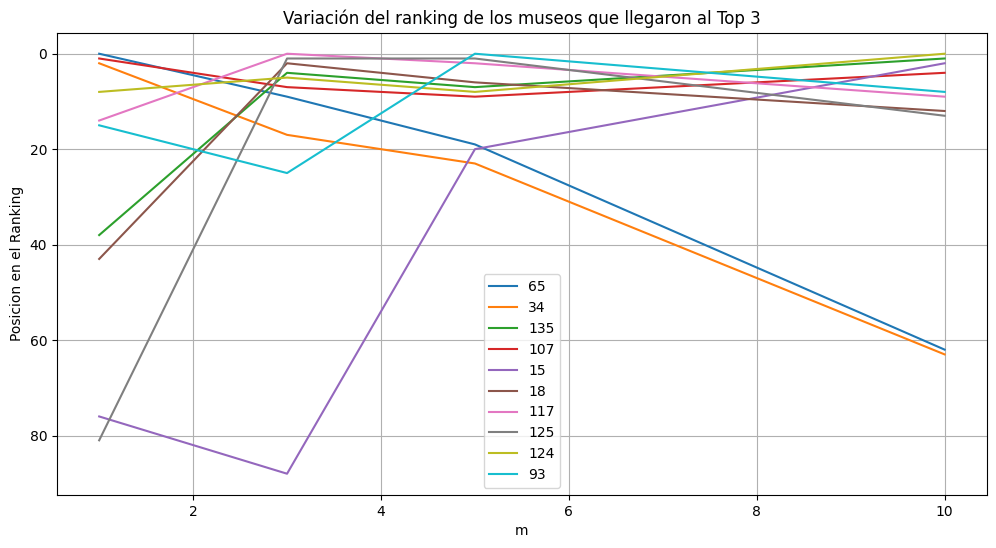

In [16]:
graficar_top3(variando_m, lista_m, 'm')


Empezaremos analizando este primer gráfico, el de la leyenda: Variación del Top 3 de PageRank segun m. Lo primero que vemos es que los valores en el ranking no son estables, principalmente para el top 3, el top 2 un poco menos y vemos que para los más visitados (top 1) ya hay una mayor estabilidad, aunque nada destacable. Con un m muy bajo quedan distribuidos de forma un poco más esparsa (ver perimer grafo de abajo). Cuanto más nos acercamos a m's mas grandes queda un grafo con los nodos del top 3 cada vez más concentrados. Además, cuando se toma un m notablemente mayor al resto como es el caso del 10, la locación de donde están concentrados los museos también cambia.

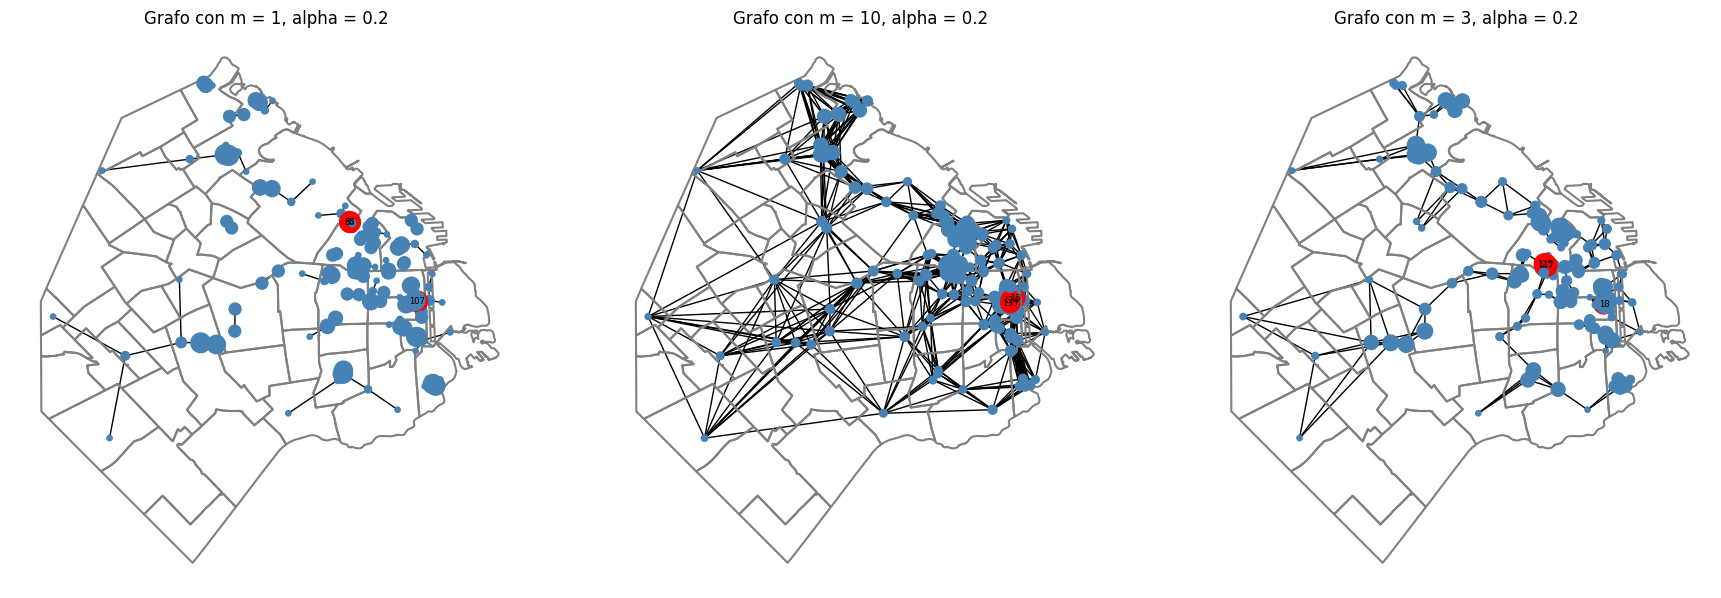

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
for j, i in enumerate([0,3,1]):
    graficar_grafo(D, variando_m[i][1], 1/5, barrios, 3, G_layout, ax=axs[j])
plt.tight_layout()
plt.show()

Para redes con pocas conexiones, aparecen museos como el 65 o 34, ubicados un poco más lejos del centro y en una zona ya sin tantos museos como otras (las dos principales en el centro de la ciudad). Se puede ver esto en el primer grafo arriba de este texto.

Para redes con muchas conexiones cambian también los nodos del top 3, aparecen el 15, 124 y 135, todos ubicados en la zona del centro de la ciudad como se puede ver en el segundo grafo.

Notamos una mayor estabilidad en la aparicion de nodos en el top 3 para m's intermedios, aunque nada remarcable, geograficamente para m = 3 se distribuyen entre 2 zonas. Lo dejamos visualmente representado en el tercer grafo. Ahora veamos el top 3.

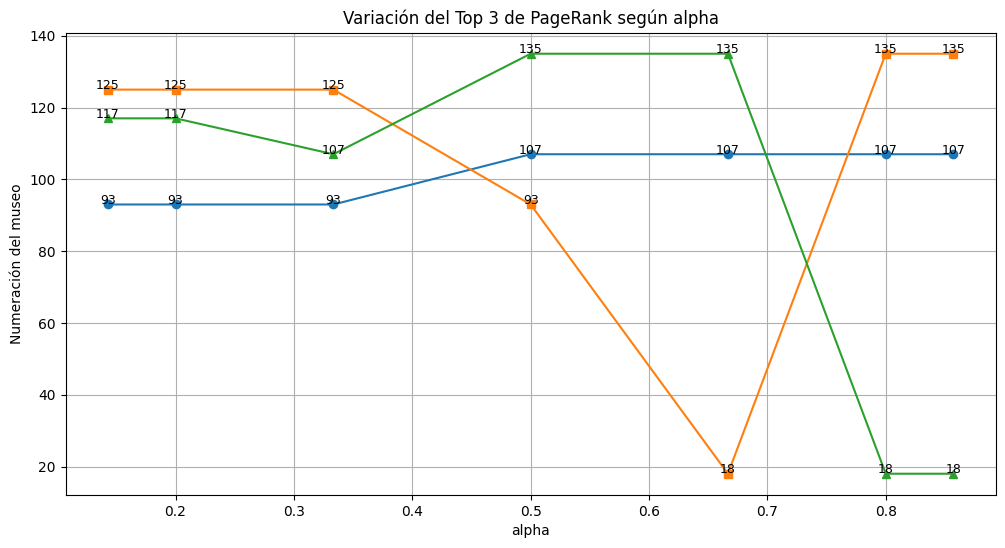

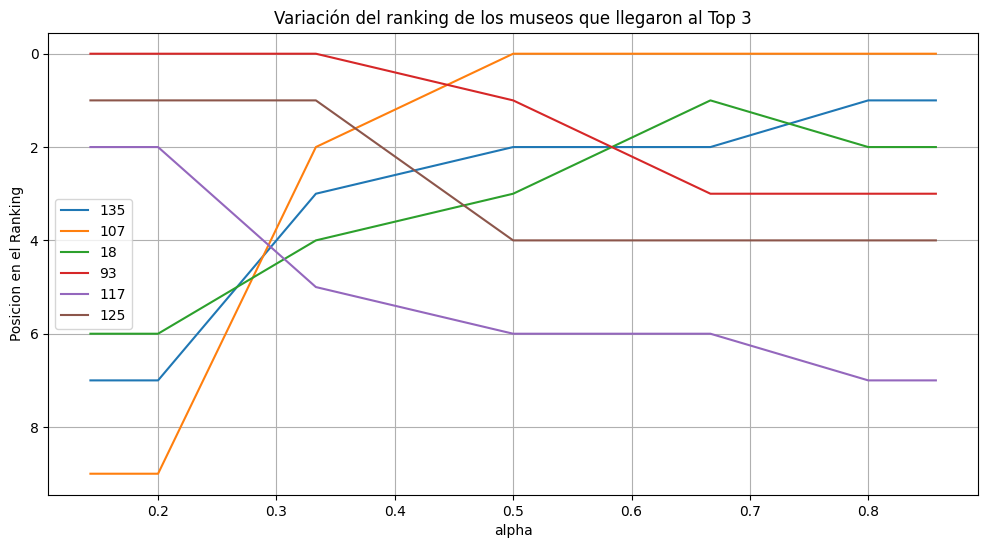

In [18]:
graficar_top3(variando_alpha, lista_alpha, "alpha")

En el segundo gráfico se ve una mayor estabilidad que en el primero. Se repiten muchos más nodos que en el grafico anterior ademas de mantenerse en la misma posicion para distintos $\alpha$. Si vemos el grafo, los nodos del top 3 se concentran en las mismas 2 zonas para todo $\alpha$ salvo los intermedios 1/2 y 1/3, en los que hay un nodo más alejado del resto (sigue estando en una de las 2 zonas predominantes). 

Podemos notar que la cantidad de conexiones (m) tiene una mayor incidencia que el $\alpha$ ya que en este caso no hay tanta variacion entre museos dentro del top 3 como en el caso del m. Dejaremos debajo de este texto varios ejemplos de grafos con los distintos alphas para ilustrar nuestro punto.

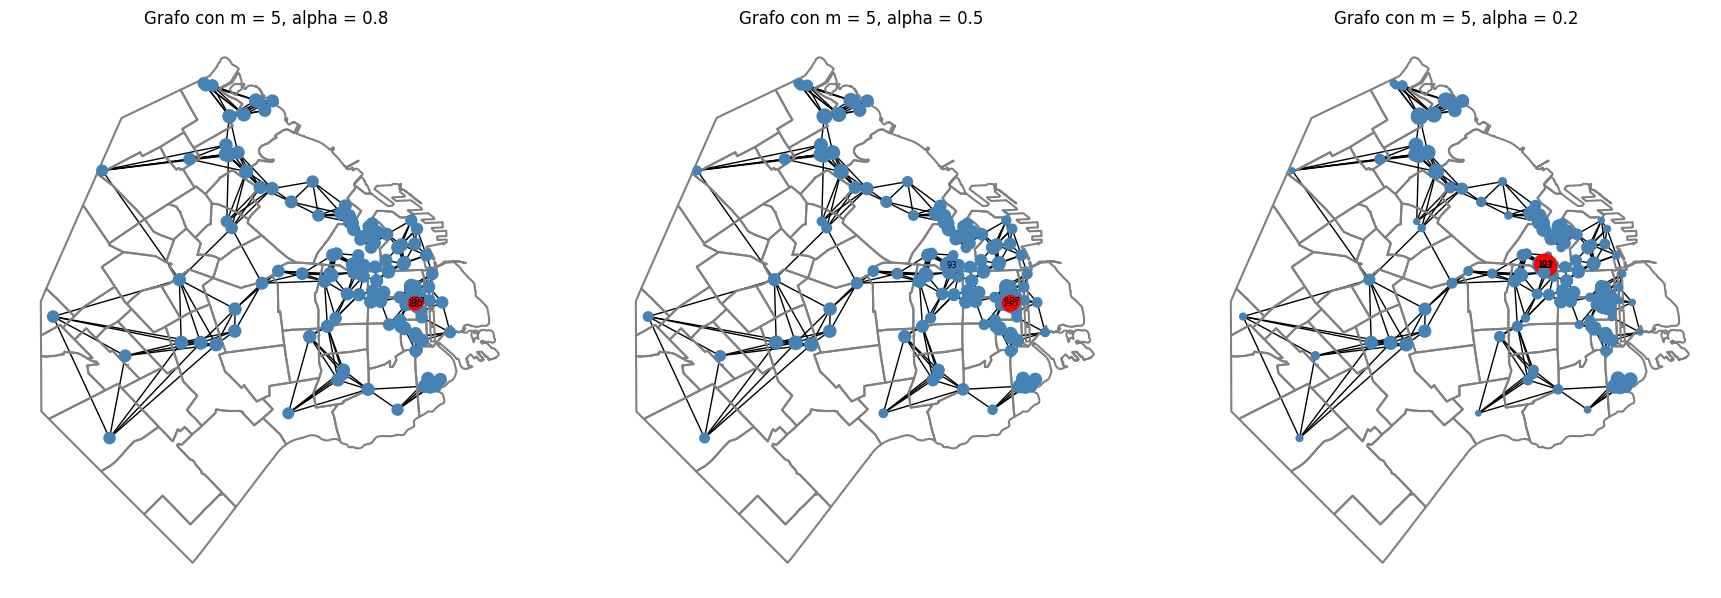

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
for j, i in enumerate([1,3,5]):
    graficar_grafo(D, 5, variando_alpha[i][1], barrios, 3,G_layout, ax=axs[j])
plt.tight_layout()
plt.show()

En general y como ya hemos mencionado, los nodos del top 3 están principalmente en 2 zonas de la Ciudad de Buenos Aires, ambas en el centro y con gran cantidad de nodos a su alrededor, se podría decir que estan ubicados en zonas densas en nodos (con muchos museos) salvo en casos de m muy bajo (como m=1).

Al aumentar $\alpha$ se vuelve más predominante la zona cerca de Puerto Madero y al hacer lo mismo para m se vuelve más predominante esa misma zona, aunque para m=5 y alpha = 1/5 todavía no se llegaban a concentrar puramente allí.

## Punto 4:

Como dado el enunciado se asume que $B$ tiene inversa, para ver que $v=B^{-1}w$ vamos a mostrar que $Bv=w$.

El numero total de visitantes que tiene el museo $i$ luego de r visitas es la sumatoria de los visitantes a ese museo luego de cada transicion.

Sabemos que la distribucion de visitantes en los museos en la k-esima transicion es $C^kv$. Por lo tanto la cantidad de visitantes que pasaron por el museo i es $w_i = v_i + (Cv)_i + ... + (C^{r-1}v)_i$


Luego $w = v + Cv + ... + C^{r-1}v = \sum^{r-1}_{k=0}C^kv = (\sum^{r-1}_{k=0}C^k)v = Bv$

Como B es inversible: $v=B^{-1}w$

## Punto 5:

Proponemos la siguiente solución al sistema pedido y graficamos el vector resultante para la matriz D en un gráfico de barras para una mayor facilidad de ver lo que significa. Hacemos uso también de factorización LU para hacer este cómputo.

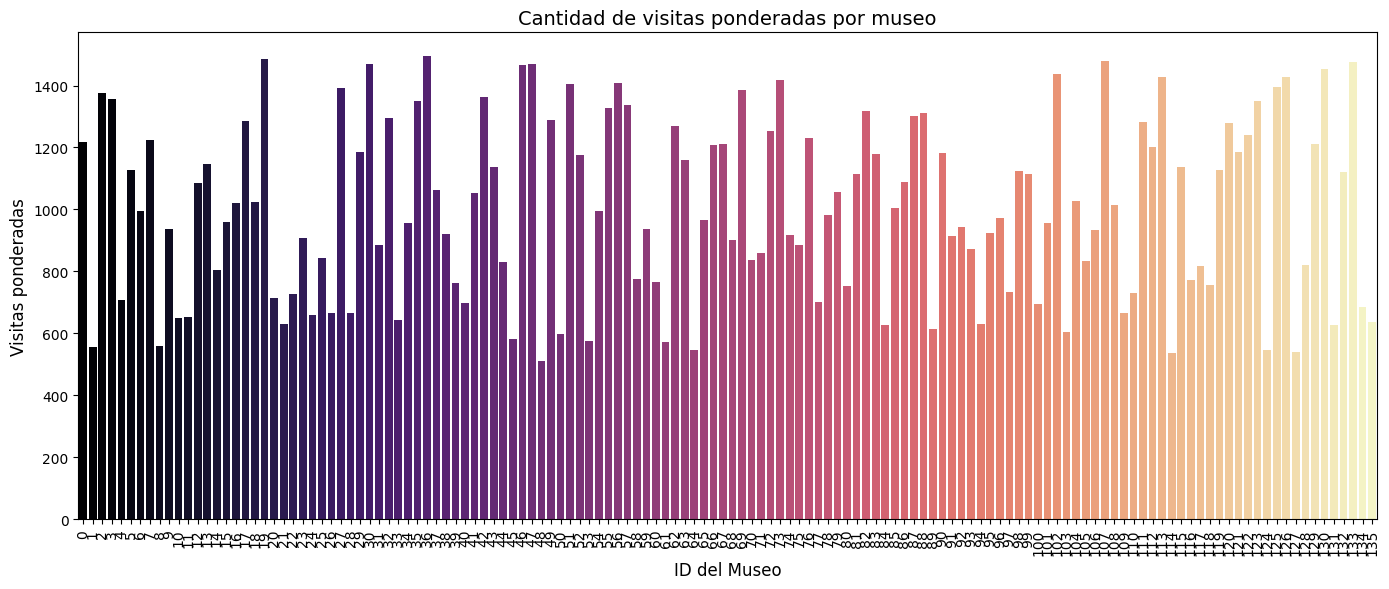

In [20]:
w = np.loadtxt("visitas.txt")
C = calcula_matriz_C_continua(D)
B = calcula_B(C,3)
L, U = calculaLU(B)
Up = scipy.linalg.solve_triangular(L,w,lower=True) # Primera inversión usando L
v = scipy.linalg.solve_triangular(U,Up) # Segunda inversión usando U

# Armamos el dataFrame
df_visitas = pd.DataFrame({
    'Museo': np.arange(len(v)),
    'Visitas': v
})

# Ordenamos por visitas el dataFrame
df_visitas = df_visitas.sort_values(by='Visitas', ascending=False)

# Armamos el grafico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=df_visitas, x='Museo', hue = 'Museo', y='Visitas', palette='magma', legend = False)
plt.title("Cantidad de visitas ponderadas por museo", fontsize=14)
plt.xlabel("ID del Museo", fontsize=12)
plt.ylabel("Visitas ponderadas", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Punto 6:

Proponemos la siguiente solución al ejercicio, haciendo uso de la función creada por nosotros y que está en el template llamada numero_de_condicion.

In [21]:
num_cond = numero_de_condicion(B) # El valor calculado por nuestra funcion
print("Numero de condicion:",num_cond)

print(np.linalg.cond(B,1))

Numero de condicion: 5.051771176665007
5.051771176665003


El error del numero total de visitantes es 5% es decir $\frac{\left\lVert w - \tilde{w} \right\rVert_1}{\left\lVert w \right\rVert_1} = 0,05$. Por otro lado calculamos $cond_1(B) \approx 5,05$. Entonces:

$\frac{\left\lVert v - \tilde{v} \right\rVert_1}{\left\lVert v \right\rVert_1} \leq 5,05 * 0,05 = 0,2525$

O sea que podemos afirmar que el error de v es como mucho del 25,25%. Un valor muy alto.

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, '6'),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

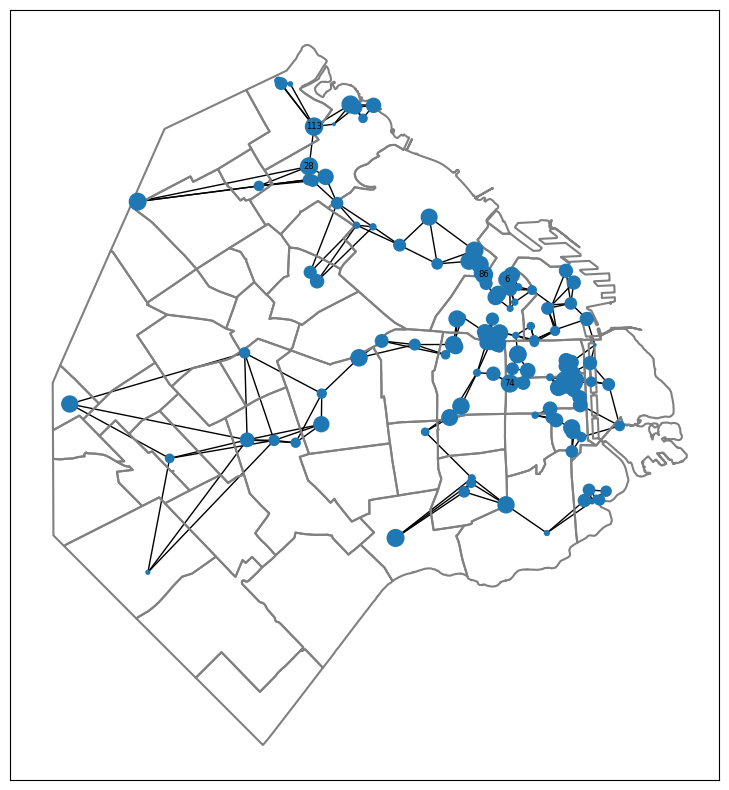

In [22]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

# TP2

## Punto 1

a) Queremos mostrar que $\vec{1}$ es autovalor de R y L

Sabemos que $L = K - A$ y $R = A - P \\$.
Entonces  $\space L \cdot \vec{1} = K \cdot \vec{1} - A \cdot \vec{1}$  y  $R \cdot \vec{1} = A \cdot \vec{1} - P \cdot \vec{1}$. 

Multiplicar por 1 a la derecha nos va a dar un vector columna que en la fila i tiene la suma de los elementos de la fila i:

$(A \cdot \vec{1})_{ij} = \sum^n_{r=1}A_{ir} \cdot \vec{1}_{rj} = \sum^n_{r=1}A_{ir} \cdot 1 =  \sum^n_{r=1}A_{ir} = k_i \\$  
$A \cdot \vec{1}$ es el vector columna con $k_i$ en la fila i.

Análogamente para K,

$(K \cdot \vec{1})_{ij} = \sum^n_{r=1}K_{ir} \cdot \vec{1}_{rj} = \sum^n_{r=1}K_{ir} \cdot 1 = \sum^n_{r=1}K_{ir} = K_{ii} = k_i \\$

Vemos que $(A \cdot \vec{1})_{ij} = (K \cdot \vec{1})_{ij} \Rightarrow A \cdot \vec{1} = K \cdot \vec{1} \Rightarrow K \cdot \vec{1} - A \cdot \vec{1} = (K - A) \cdot \vec{1} = L \cdot \vec{1} =  \vec{0} \\$

Análogamente para P,

$(P \cdot \vec{1})_{ij} = \sum^n_{r=1}P_{ir} \cdot \vec{1}_{rj} = \sum^n_{r=1} (\frac{k_i k_r}{2E}) \cdot 1 = \frac{k_i}{2E} \sum^n_{r=1} k_r = \frac{k_i}{2E} \sum^n_{r=1}\sum^n_{l=1}A_{rl} = \frac{k_i}{2E} \cdot 2E = k_i$

Vemos que $(A \cdot \vec{1})_{ij} = (P \cdot \vec{1})_{ij} \Rightarrow (A - P) \cdot \vec{1} = R \cdot \vec{1} =  \vec{0} \\$.

Así podemos afirmar que $\vec{1}$ es autovector de R y L de autovalor 0. Además, $\vec{1}$ representa la red donde todos los nodos son parte del mismo grupo.

b) Para L y R, sean $v_1$ y $v_2$ autovectores con autovalores $ \lambda_1 \neq \lambda_2 \Rightarrow v_1^t v_2 = 0$

Sabemos que tanto L como R son matrices simétricas:

- A es simétrica ya que las redes que usamos son sin dirigir
- K es simétrica ya que es una matriz diagonal
- P es simétrica ya que: $P_{ij} = \frac{k_i k_j}{2E} = \frac{k_j k_i}{2E} = P_{ji}$

La diferencia entre matrices simétricas es una matriz simétrica $\Rightarrow$ L y R son matrices simétricas.
Las matrices simétricas son un caso particular de las matrices hermitiana, por lo que cumplen sus propiedades.
Sabemos que los autovectores de una matriz hermitiana forman una base ortogonal. Entonces el producto interno entre dos autovectores de autovalor diferente es 0. $v^t w = <v,w>$ es un producto interno, por lo tanto $v_1^t v_2 = 0$.

Otra demostración es:

Veamos que pasa con $v_1^t M v_2$ para M una matriz simétrica:

$v_1^t M v_2 = v_1^t \lambda_2 v_2 = \lambda_2 v_1^t v_2$

Pero también

$v_1^t M v_2 = (M^t v_1)^t v_2 = (M v_1)^t v_2 = (\lambda_1 v_1)^t v_2 = \lambda_1 v_1^t v_2$

Luego: 

$\lambda_2 v_1^t v_2 = \lambda_1 v_1^t v_2 \Rightarrow \lambda_2 v_1^t v_2 - \lambda_1 v_1^t v_2 = (\lambda_2 - \lambda_1) v_1^t v_2 = 0$

$\lambda_2 - \lambda_1 = 0 \lor v_1^t v_2 = 0$ Pero por hipótesis $\lambda_2 \neq \lambda_1 \Rightarrow \lambda_2 - \lambda_1 \neq 0$

Por lo tanto: $v_1^t v_2 = 0$

c) mostrar $Lv = \lambda v \lor Rv = \lambda v , \lambda \neq 0 \Rightarrow \sum_i v_i = 0$

notemos que $\sum_i v_i = \vec{1}^t v = <\vec{1},v>$ 

En el inciso a vimos que $\vec{1}$ es un autovector de L y R de autovalor 0.

En el inciso b vimos que, para matrices simétricas, el producto interno entre dos autovectores de autovalor diferente es 0.

como v es autovector con autovalor $\lambda \neq 0$ , y el autovalor de $\vec{1}$ es 0 $\Rightarrow$ $\vec{1}^t v = \sum_i v_i = 0$

## Punto 2


a) Queremos mostrar que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$ y el autovector asociado es $v_i$.

Nos basta con mostrar que ($M + \mu I) v_i = \gamma_i v_i$:

($M + \mu I) v_i = M v_i + \mu I v_i = \lambda_i v_i + \mu v_i = (\lambda_i + \mu) v_i = \gamma_i v_i$

Una matriz es invertible sii ninguno de sus autovalores es igual a 0. Los autovalores de $M + \mu I$ son los $\gamma_i$, luego si $\forall i, \gamma_i = \lambda_i + \mu \neq 0 \Rightarrow M + \mu I$ es invertible.

b) sea $\mu > 0$ mostrar que $L + \mu I$ es invertible.

Sabemos que L es semidefinida positiva, es decir $v^t L v \geq 0 \quad \forall x \in \R^n$ lo que implica que todos sus autovalores son positivos.

Como L es simétrica, es diagonalizable y todos sus autovalores son reales, y por lo mostrado en el inciso a si $\lambda_i$ es autovalor de L entonces $\lambda_i + \mu$ es autovalor de $L + \mu I$.

Una matriz es invertible sii ninguno de sus autovalores es igual a 0, como los autovlaores de $L + \mu I$ son $\lambda_i + \mu$ y sabemos que $\mu \gt 0 \land \lambda_i \geq 0 \Rightarrow \lambda_i + \mu \gt 0 \Rightarrow \lambda_i + \mu \neq 0$ por lo tanto, como ningún autovalor es igual a, 0 $L + \mu I$ es invertible.

Como los autovalores de la inversa de una matriz son los inversos de los autovlaores, el autovalor mas chico de la matriz se corresponde con el mas grande de la matriz inversa:
Los autovlaores de $(L + \mu I)^{-1}$ son $\gamma'_i = \frac{1}{\gamma_i}$ donde $\gamma_i$ es un autovalor de $L + \mu I$.
Luego $max\{\gamma´_i\}=max\{\frac{1}{\gamma'_i}\} = \frac{1}{min\{\gamma'_i\}} $

Como los autovalores de L son mayores o iguales a 0, y en el punto 1 mostramos que $\vec{1}$ es un autovector de autovalor 0 de L, luego el autovalor mínimo de L es 0. Podemos ver que $min\{\gamma_i\}=min\{\lambda_i+\mu\}=min\{\lambda_i\}+\mu= 0 + \mu = \mu$ 

Entonces, en caso que haya un solo autovector asociado al mínimo, el método va a converger al autovalor 0 con autovector $\vec{1}$

c) Queremos mostrar que para M una simétrica, $M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1}$ tiene los mismos autovalores que M excepto el asociado a $v_1$ que es igual a 0

Notemos que $v_1^t v_1 = ||v||_2^2$ que lo vamos a escribir como $||v_1||^2$.

Sea $\{v_1, v_2, ... v_n\}$ una base ortogonal de autovectores de autovalores $\lambda_1,\lambda_2,...,\lambda_n$.

Veamos que pasa cuando multiplicamos por un autovector $v_i$:

$(M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1}) v_i = Mv_i - \lambda_1 \frac{v_1 v_1^t}{||v_i||^2} v_i = \lambda_i v_i - \lambda_1 v_1 \frac{v_1^t v_i}{||v_i||^2}$

Notemos que como estamos en una base ortogonal:

$v_1^t v_i = \left\{ \begin{array}{lcc} ||v_1||^2 & si & i = 1 \\ 0 & sino \end{array} \right.$

Caso i = 1: 

$\lambda_1 v_1 - \lambda_1 v_1 \frac{v_1^t v_1}{||v_1||^2} = \lambda_1 v_1 - \lambda_1 v_1 \frac{|| v_1 ||^2}{||v_1||^2} = \lambda_1 v_1 - \lambda_1 v_1 = 0$

Caso i $\neq$ 1:

$\lambda_i v_i - \lambda_1 v_1 \frac{v_1^t v_i}{||v_i||^2} = \lambda_i v_i - \lambda_1 v_1 \frac{0}{||v_i||^2} = \lambda_i v_i$

Por lo tanto los autovalores se mantienen excepto para $v_1$, que es 0.

## Punto 3

a) Para calcular el corte y modularidad de las particiones esperadas primero tenemos que calcular los autovectores que me darían la partición optima basándonos en estos métodos. Para $\Lambda$ debemos usar el autovector asociado al menor autovalor posible de la matriz laplaciana. Como es una red simple y se pide la partición esperada, le pasaré a las funciones calcula_lambda y calcula_Q el vector v=s=(-1,-1,-1,-1,1,1,1,1) como parámetro, lo que representa la clara división en 2 grupos a simple vista. Esto funcionará pues lo que importa para estos cálculos son los signos de los elementos del autovector.

In [23]:
laplaciana = calcula_L(A_ejemplo)


Además podemos verificar que es correcta la implementación, ya que lo contrastamos con la implementación de scipy a través de la función check_laplaciana y devuelve que son equivalentes.

In [24]:
print(check_laplaciana(A_ejemplo))

True


Ahora si podemos calcular $\Lambda$ con la función calcular_lambda.

In [25]:
varLambda = calcula_lambda(laplaciana, [-1,-1,-1,-1,1,1,1,1])
print(varLambda)

2.0


Luego, podemos ver que el corte de las partición esperada es 2, lo cual coincide con lo intuitivo.

Para ver la modularidad esperada también usaremos el mismo s como ya aclaramos. La matriz R la calcularemos con la función calcula_R.

In [26]:
R = calcula_R(A_ejemplo)

Con esto podemos calcular la modularidad Q, usando la función calcula_Q.

In [27]:
cantidad_de_aristasEj = calcula_cant_aristas(A_ejemplo)
Q = calcula_Q(R, [-1,-1,-1,-1,1,1,1,1], cantidad_de_aristasEj)
print(Q)

0.3571428571428571


Y también como podemos ver, la modularidad de la partición esperada es 0.3571.


b) Para obtener el autovector asociado al segundo autovalor más chico de L deberíamos aplicar el método de la potencia inverso sobre la matriz deflacionada L. Como vimos en los ejercicios anteriores sabemos que los autovalores de $L + \mu I$ son $\gamma_i = \lambda_i + \mu$ y que el autovector asociado a $\gamma_i$ es $v_i$, que es el buscado. Por tanto si obtenemos el autovalor $\gamma_i$ podremos también obtener $\lambda_i$ pues $\lambda_i = \gamma_i - \mu$. Luego bastará con hacer uso de la función metpotI2 (pues queremos obtener el segundo más chico) y hacer las operaciones mencionadas si quisiésemos el autovalor asociado a L. Pondremos un $\mu = 1$ por simplicidad. 


Ahora si, calculamos el autovector y autovalor de L con el shifting.


In [28]:
autovector_laplacianaS = metpotI2(laplaciana, mu=1)[0]
print(autovector_laplacianaS)

[-0.42535939 -0.42537734 -0.26292019 -0.26290764  0.26282524  0.26281246
  0.42525857  0.42530424]


Ahora para saber el autovector asociado al autovalor más de R hay que hacer un proceso similar. Hay que calcular R haciendo uso de calcular_R y luego hacer el metodo de la potencia standard, sin inversas, asi obtenemos lo deseado. Esta función es metpot1.

Calculemos el autovector asociado al mayor autovalor de R

In [29]:
autovector_R = metpot1(R)[0]
print(autovector_R)

[ 0.39410272  0.39410272  0.30775001  0.30766219 -0.30766219 -0.30775001
 -0.39410272 -0.39410272]


Podemos corroborar que los autovectores obtenidos son correctos gracias a la funcion propia checkMetPots.

In [30]:
print(checkMetPots(R, laplaciana))

True


Ya teniendo estos resultados podemos calcular los s respectivos a los que llamaremos sL y sR para el del autovector de la laplaciana y el de R respectivamente. Lo haremos con la función propia llamada calcula_s, que toma un vector v (en este caso autovector) y en base a los signos de sus elementos pone un 1 si es positivo y -1 si es negativo.


In [31]:
sL = calcula_s(autovector_laplacianaS)
sR = calcula_s(autovector_R)

print(sL, sR)

[-1. -1. -1. -1.  1.  1.  1.  1.] [ 1.  1.  1.  1. -1. -1. -1. -1.]


Ahora que tenemos los s respectivos, vemos que se divide en 2 grupos como esperabamos. Y también con los que dimos en el punto a) de este ejercicio. El resultado es el mismo. Tendriamos que ver posteriormente una particion exactamente igual. Esto quiere decir que ambos autovectores están detectando perfectamente la clara separación entre grupos que hay en el grafo de ejemplo, a pesar de que se basan en métodos distintas.

c) Antes de apicar las funciones es importante remarcar que para que la funcion laplaciano_iterativo me devuelva una particion en 4 grupos las cantidad de niveles debe ser dos pues sabemos que para k niveles obtenemos $2^k$ particiones. Sabiendo esto, podemos aplicar las funciones y ver que particiones obtenemos.

In [32]:
particion_laplaciano = laplaciano_iterativo(A_ejemplo, 2)
print(particion_laplaciano)

[[0, 3], [1, 2], [4, 5], [6, 7]]


In [33]:
particion_modularidad = modularidad_iterativo(A_ejemplo)
print(particion_modularidad)

[[0, 1, 2, 3], [4, 5, 6, 7]]


Es importante aclarar que la numeración de los nodos listados es el nodo original-1. Por ejemplo, el nodo 0 en nuestra lista es el 1 en la Figura 1 del enunciado. Cabe recalcar que si se nos hubiese pedido una particion en 2 grupos usando el laplaciano tendriamos exactamente la misma partición. Esto mismo es lo que pudimos ver en el punto b) de este ejercicio, vimos que se partía en 2 comunidades marcadas, que a simple vista también es reconocible. La partición que nos da el laplaciano iterativo en 4 grupos también es coherente. Lo que sí, notamos que las particiones que nos devuelve este metodo son inestables, es decir, ejecutandolo multiples veces nos dan particiones validas pero distintas (salvo cuando se piden solo 2 particiones o en este caso 3, pues $2^3 = 8$ y $|V| = 8$ siendo V el conjunto de nodos de la red de ejemplo dada). Siendo un conjunto de nodos tan chico y habiendo 2 grupos tan marcados no parece ser problema la inestabilidad del algoritmo.

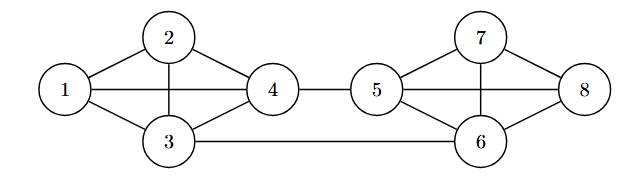

## Punto 4

Ahora queremos calcular las particiones óptimas usando los métodos iterativos del ejercicio anterior. Para esto, recordamos que la matriz A es la de adyacencia creada a partir de la matriz de distancias D, y es la que representa nuestra red de museos. Por tanto, aplicaremos los algoritmos sobre esa matriz A. (Vamos a tener que cambiar calcular_Q).
Antes de aplicarlos, deberemos simetrizar la matriz realizando: $A' = \left\lfloor \frac{1}{2}(A + A^t) \right\rfloor$. Para eso usamos la funcion simetrizar hecha por nosotros, que es una implementación computacional de la formula dada.

Primero simetricemos la matriz A con m = 3 y calculemos su cantidad de aristas con la funcion propia calcula_cant_aristas. Primero lo haremos con el metodo del laplaciano, separando en 2 y 4 grupos, para eso pasaremos como parametro niveles=1 y niveles=2 respectivamente. Aunque para poder comparar más directamente iremos calculando el laplaciano iterativo con la cantidad de niveles que más nos acerque a las particiones dadas por la modularización.

In [34]:
A3 = construye_adyacencia(A, 3)
A3s = simetrizar(A)
cantidad_de_aristasA3 = calcula_cant_aristas(A3s)
particionL_3_en2 = laplaciano_iterativo(A3s, 1)
particionL_3_en4 = laplaciano_iterativo(A3s, 2)

Usaremos la funcion mostrar_particion para ver los resultados. Primero veamos la particion en 2 grupos con el laplaciano:

In [35]:
mostrar_particion(particionL_3_en2)

| Grupo   | Nodos                                                                                                                                                                                                                                                                                                                                                                                                                     |
|:--------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 0, 2, 5, 7, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 23, 31, 32, 33, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 51, 54, 56, 58, 59, 60, 6

Ahora la particion en 4 grupos:

In [36]:
mostrar_particion(particionL_3_en4)

| Grupo   | Nodos                                                                                                                                                                                                                                                  |
|:--------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 23, 32, 35, 38, 40, 43, 47, 48, 56, 59, 61, 63, 66, 78, 83, 98, 105, 107, 115, 116, 118, 123, 124, 128, 129, 133, 135                                                                                      |
| Grupo 2 | 7, 20, 31, 33, 36, 37, 41, 44, 45, 46, 51, 54, 58, 60, 62, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 81, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 106, 108, 109, 110, 111, 112, 114, 11

Habiendo visto los resultados con el metodo del laplaciano iterativo, veamos que sucede usando la modularizacion iterativa. Para eso debemos construir R antes.

In [37]:
RA3 = calcula_R(A3s)
particionM_3 = modularidad_iterativo(A3s, RA3)

Y ahora veamos los resultados en una tabla: 

In [38]:
mostrar_particion(particionM_3)

| Grupo    | Nodos                                                                  |
|:---------|:-----------------------------------------------------------------------|
| Grupo 1  | 6, 17, 25, 42, 87, 88, 89, 126, 130, 131                               |
| Grupo 2  | 23, 24, 34, 38, 43, 56, 65, 86, 105, 129, 133                          |
| Grupo 3  | 95, 96, 103                                                            |
| Grupo 4  | 20, 36, 37, 60, 76, 81, 104, 108, 122, 134                             |
| Grupo 5  | 1, 26, 28, 29, 49, 50, 52, 53, 55, 57, 82, 85, 113                     |
| Grupo 6  | 8, 19, 27, 30, 77, 79, 80, 84                                          |
| Grupo 7  | 45, 54, 62, 100, 102, 109, 112                                         |
| Grupo 8  | 31, 99, 101, 119, 127                                                  |
| Grupo 9  | 9, 21, 32, 35, 47, 48, 63, 66, 115                                     |
| Grupo 10 | 3, 4, 11, 22, 33, 39, 97                 

Viendo que la partición dada por modularidad es en 18 grupos, veamos si la partición con el laplaciano en 16 grupos.

In [39]:
particionL_3_en16 = laplaciano_iterativo(A3s, 4)

In [40]:
mostrar_particion(particionL_3_en16)

| Grupo    | Nodos                                                                                                        |
|:---------|:-------------------------------------------------------------------------------------------------------------|
| Grupo 1  | 42, 88, 89, 126, 131                                                                                         |
| Grupo 2  | 6, 17, 25, 87, 130                                                                                           |
| Grupo 3  | 11, 24, 34, 65, 86                                                                                           |
| Grupo 4  | 3, 4, 22, 39                                                                                                 |
| Grupo 5  | 1, 26, 28, 29, 50, 55                                                                                        |
| Grupo 6  | 49, 52, 53, 57, 82, 85                                                                                       |
| Grupo 

Ahora veamos los distintos grafos:

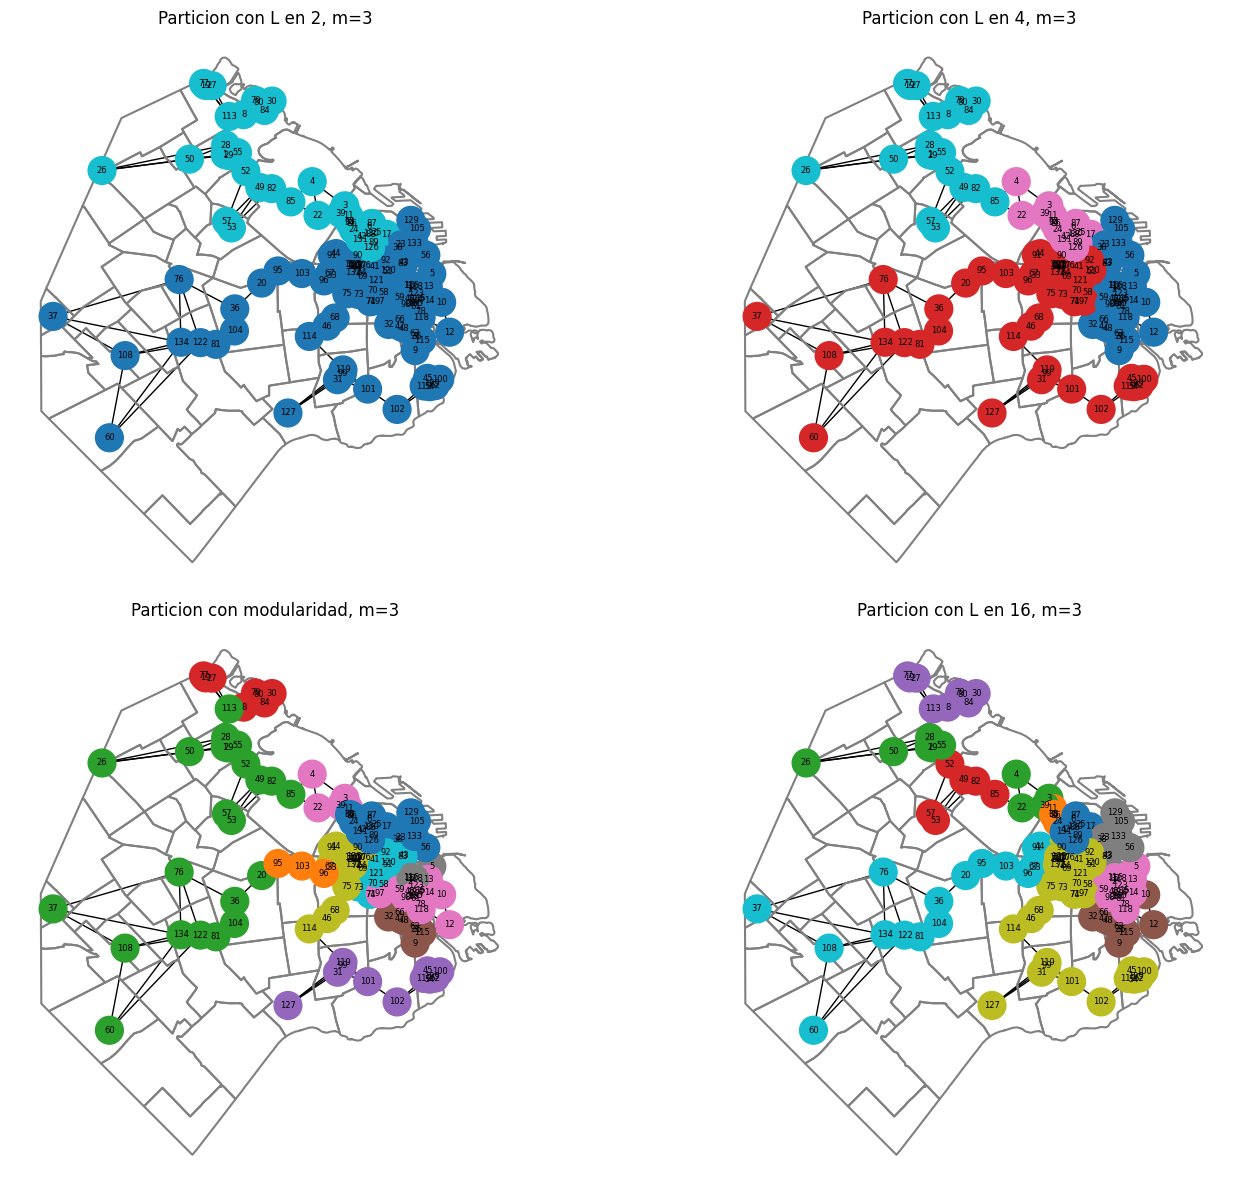

In [ ]:
particiones = [
    (particionL_3_en2, "Particion con L en 2, m=3"),
    (particionL_3_en4, "Particion con L en 4, m=3"),
    (particionM_3, "Particion con modularidad, m=3"),
    (particionL_3_en16, "Particion con L en 16, m=3")
]
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs = axs.flatten()

for i, (particion, titulo) in enumerate(particiones):
    grafo_particion(A3s, particion, titulo, G_layout, barrios, ax=axs[i])

for j in range(len(particiones), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

Podemos ver que por lo menos para una cantidad de conexiones chica como lo es 3 el metodo iterativo del laplaciano parece tener agrupaciones "intuitivas" mientras que las particiones resultantes de la modularización nos dio una separación coherente en ciertos lugares y en otras, no tanto. Donde menos claridad hay en el por qué de las separaciones es en las zonas de más densidad de nodos, ya que en ciertos grupos algunos nodos están separados entre sí. Sobre la separación en 2 a través del metodo iterativo del laplaciano no mencionaremos más que nos da una separación en grupos esperable y que no resulta últil para comparar con la que nos da modularidad. Por eso, veremos la separacion en 16 grupos dada por la ejecucion del laplaciano iterativo en 4 niveles.

Viendo la partición que nos dio el Laplaciano en 16 grupos resulta similar pero con ciertas diferencias a la que nos da la modularidad. Podemos ver que el laplaciano realiza particiones en zonas menos densas en nodos como el norte y en zonas densas los grupos son compactos geográficamente.

Ahora con m = 5, para eso debemos reconstruir A. Repetiremos el proceso de visualizar los resultados en tablas y luego con el grafo.

In [42]:
A5 = construye_adyacencia(D, 5)
A5s = simetrizar(A5)
cantidad_de_aristas = calcula_cant_aristas(A5s)
particionL_5_en2 = laplaciano_iterativo(A5s, 1)
particionL_5_en4 = laplaciano_iterativo(A5s, 2)

Empecemos con la partición en 2.

In [43]:
mostrar_particion(particionL_5_en2)

| Grupo   | Nodos                                                                                                                                                                                                                                                                                                   |
|:--------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 0, 2, 5, 7, 9, 10, 12, 13, 14, 15, 16, 18, 21, 23, 31, 32, 35, 38, 40, 41, 43, 45, 46, 47, 48, 51, 54, 56, 58, 59, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 74, 78, 83, 92, 97, 98, 99, 100, 101, 102, 105, 106, 107, 109, 112, 114, 115, 116, 118, 119, 120, 121, 123, 124, 127, 128, 129, 133, 135 |
| Grupo 2 | 1, 3, 4, 6, 8, 11, 17, 19, 20, 22, 24, 25, 26, 27, 28, 29,

Ahora con la partición en 4.

In [44]:
mostrar_particion(particionL_5_en4)

| Grupo   | Nodos                                                                                                                                                                                           |
|:--------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 3, 4, 6, 11, 17, 22, 24, 25, 34, 39, 42, 49, 65, 82, 85, 86, 87, 88, 89, 126, 130, 131                                                                                                          |
| Grupo 2 | 1, 8, 19, 20, 26, 27, 28, 29, 30, 33, 36, 37, 44, 50, 52, 53, 55, 57, 60, 67, 75, 76, 77, 79, 80, 81, 84, 90, 91, 93, 94, 95, 96, 103, 104, 108, 110, 111, 113, 117, 122, 125, 132, 134         |
| Grupo 3 | 7, 31, 45, 46, 54, 62, 64, 68, 69, 70, 71, 72, 73, 74, 99, 100, 101, 102, 106, 109, 112, 114, 119, 127                                                              

Veamos que pasa con el metodo de modularización en este caso.

In [45]:
RA5 = calcula_R(A5s)
particionM_5 = modularidad_iterativo(A5s)

Y por último la de modularización:

In [46]:
mostrar_particion(particionM_5)

| Grupo    | Nodos                                                                                  |
|:---------|:---------------------------------------------------------------------------------------|
| Grupo 1  | 7, 33, 41, 44, 64, 67, 69, 72, 75, 90, 91, 93, 94, 106, 110, 111, 117, 125, 132        |
| Grupo 2  | 20, 46, 68, 70, 73, 95, 96, 103, 121                                                   |
| Grupo 3  | 8, 19, 27, 28, 30, 55, 77, 79, 80, 84, 113                                             |
| Grupo 4  | 1, 4, 26, 29, 36, 37, 49, 50, 52, 53, 57, 60, 76, 81, 82, 85, 104, 108, 122, 134       |
| Grupo 5  | 6, 17, 24, 25, 42, 87, 88, 89, 126, 129, 130, 131                                      |
| Grupo 6  | 23, 38, 105, 133                                                                       |
| Grupo 7  | 31, 45, 54, 62, 99, 100, 101, 102, 109, 112, 114, 119, 127                             |
| Grupo 8  | 3, 11, 22, 34, 39, 43, 51, 58, 65, 71, 74, 83, 86, 92, 120           

Como con m=3, veamos como sería la partición esta vez en 8 grupos que nos da el laplaciano, la más cercana en particiones a la modularidad.

In [47]:
particionL_5_en8 = laplaciano_iterativo(A5s, 3)


In [48]:
mostrar_particion(particionL_5_en8)

| Grupo   | Nodos                                                                                                                              |
|:--------|:-----------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 3, 4, 11, 22, 24, 34, 39, 49, 65, 82, 85, 86                                                                                       |
| Grupo 2 | 6, 17, 25, 42, 87, 88, 89, 126, 130, 131                                                                                           |
| Grupo 3 | 20, 33, 36, 37, 44, 60, 67, 75, 76, 81, 90, 91, 93, 94, 95, 96, 103, 104, 108, 110, 111, 117, 122, 125, 132, 134                   |
| Grupo 4 | 1, 8, 19, 26, 27, 28, 29, 30, 50, 52, 53, 55, 57, 77, 79, 80, 84, 113                                                              |
| Grupo 5 | 0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 32, 35, 40, 47, 48, 59, 61, 63, 66, 78, 97, 98, 107, 115, 116, 118, 123, 1

Ahora veamos los grafos:


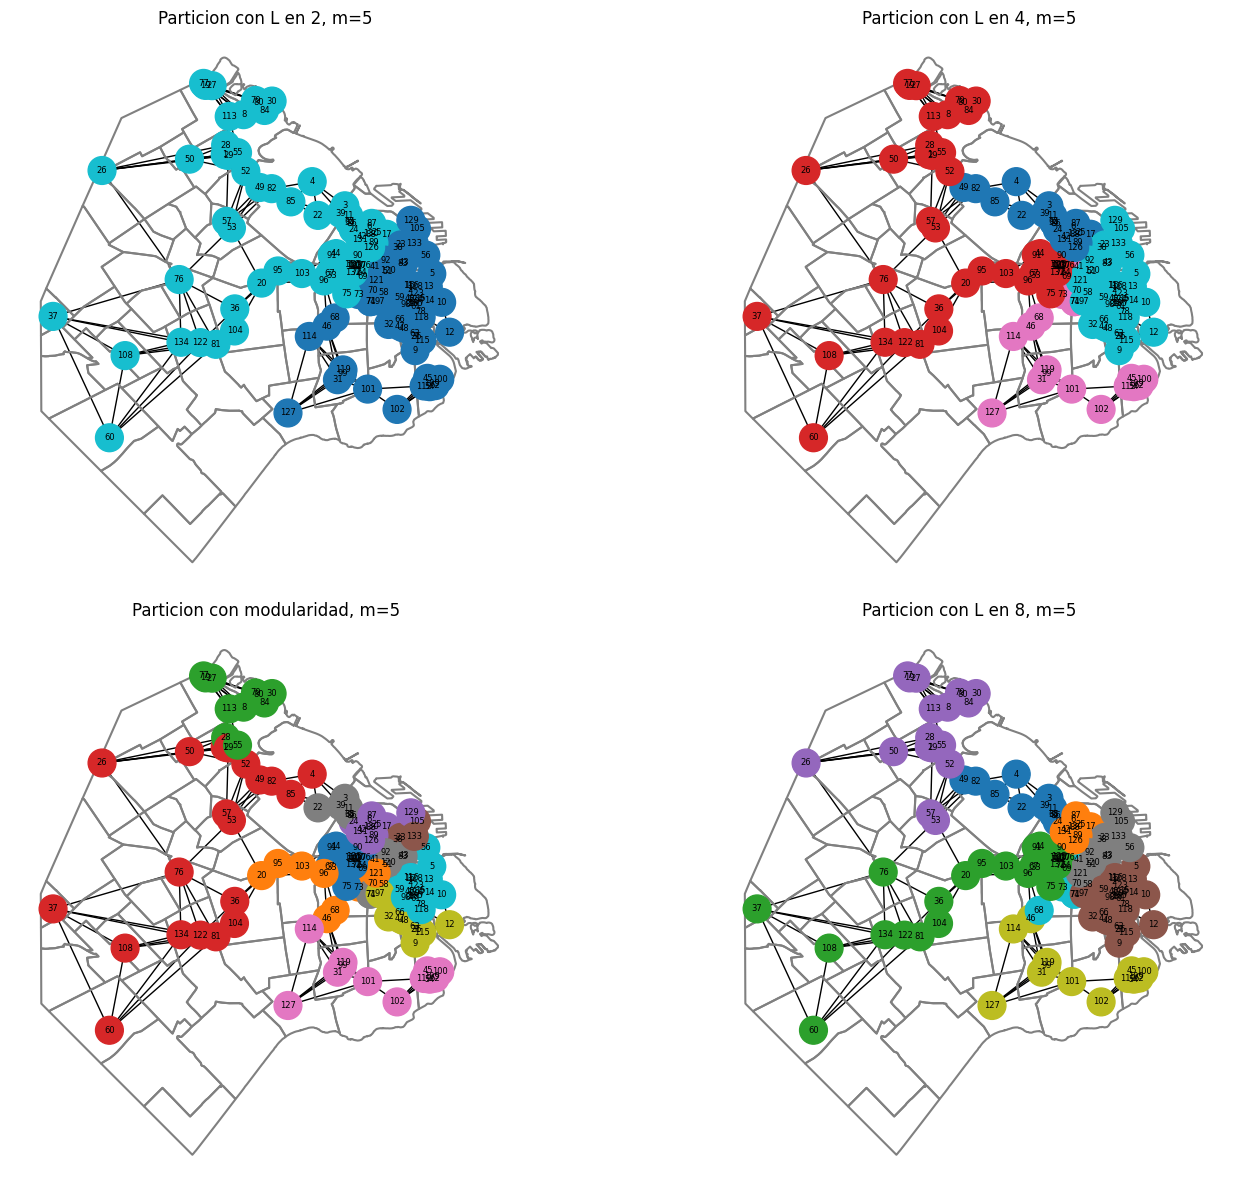

In [ ]:
particiones = [
    (particionL_5_en2, "Particion con L en 2, m=5"),
    (particionL_5_en4, "Particion con L en 4, m=5"),
    (particionM_5, "Particion con modularidad, m=5"),
    (particionL_5_en8, "Particion con L en 8, m=5")
]
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs = axs.flatten()

for i, (particion, titulo) in enumerate(particiones):
    grafo_particion(A5s, particion, titulo, G_layout, barrios, ax=axs[i])

for j in range(len(particiones), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

Nuevamente, la separación en 2 a través del método del laplaciano es esperable. Ahora bien, con el aumento de conexiones la particion en 4 grupos calculada con el laplaciano cambia aunque no radicalmente, se asemeja a la particion en 2 grupos de la que acabamos de hablar, lo cual tiene sentido por la naturaleza iterativa del algoritmo. Viendo las particiones resultantes con la modularizacion podemos ver que lo mencionado para m=3 sigue sucediendo.

En este caso, vemos que las particiones dadas por la modularidad están más concentradas geográficamente, es decir, los nodos de un mismo grupo están mas cerca entre si. De todas maneras, la dada por el laplaciano sigue dando una partición con mayor concentración entre nodos de un mismo grupo. Se debe tener en cuenta que la comparación no puede ser directa ya que 11 no es potencia de 2 y 8 es el número más cercano a 11 que es potencia de 2.

Ahora lo mismo para m=10.

In [50]:
A10 = construye_adyacencia(D, 10)
A10s = simetrizar(A10)
cantidad_de_aristas = calcula_cant_aristas(A10s)
particionL_10_en2 = laplaciano_iterativo(A10s, 1)
particionL_10_en4 = laplaciano_iterativo(A10s, 2)

Vemos las particiones en 2 y 4:

In [51]:
mostrar_particion(particionL_10_en2)

| Grupo   | Nodos                                                                                                                                                                                                                                                                                                                                        |
|:--------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 0, 2, 5, 7, 9, 10, 12, 13, 14, 15, 16, 18, 21, 23, 31, 32, 35, 38, 40, 41, 43, 45, 46, 47, 48, 51, 54, 56, 58, 59, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 78, 83, 92, 93, 94, 97, 98, 99, 100, 101, 102, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 123, 

In [52]:
mostrar_particion(particionL_10_en4)

| Grupo   | Nodos                                                                                                                                                                                 |
|:--------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 1, 8, 19, 20, 26, 27, 28, 29, 30, 33, 36, 37, 44, 49, 50, 52, 53, 55, 57, 60, 67, 76, 77, 79, 80, 81, 82, 84, 91, 95, 96, 103, 104, 108, 113, 122, 134                                |
| Grupo 2 | 3, 4, 6, 11, 17, 22, 24, 25, 34, 39, 42, 65, 85, 86, 87, 88, 89, 90, 126, 130, 131                                                                                                    |
| Grupo 3 | 7, 23, 38, 41, 43, 46, 51, 56, 58, 64, 68, 69, 70, 71, 72, 73, 74, 75, 83, 92, 93, 94, 97, 105, 106, 110, 111, 114, 117, 120, 121, 125, 129, 132, 133                                 |
| Grupo 4 | 0, 2, 5,

Nuevamente, veamos que pasa esta vez con el metodo de modularizacion

In [53]:
R10 = calcula_R(A10s)
particionM_10 = modularidad_iterativo(A10s, R10)

La vemos en la tabla:

In [54]:
mostrar_particion(particionM_10)

| Grupo   | Nodos                                                                                                              |
|:--------|:-------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 1, 8, 19, 26, 27, 28, 29, 30, 36, 37, 49, 50, 52, 53, 55, 57, 60, 76, 77, 79, 80, 81, 82, 84, 108, 113, 122, 134   |
| Grupo 2 | 3, 4, 6, 11, 17, 22, 23, 24, 25, 34, 38, 39, 42, 65, 85, 86, 87, 88, 89, 105, 126, 129, 130, 131                   |
| Grupo 3 | 20, 31, 46, 58, 68, 71, 74, 92, 99, 104, 114, 119, 127                                                             |
| Grupo 4 | 7, 33, 41, 44, 51, 64, 67, 69, 70, 72, 73, 75, 90, 91, 93, 94, 95, 96, 103, 106, 110, 111, 117, 120, 121, 125, 132 |
| Grupo 5 | 9, 12, 21, 32, 35, 45, 47, 48, 54, 62, 63, 66, 100, 101, 102, 109, 112, 115                                        |
| Grupo 6 | 0, 2, 5, 10, 13, 14, 15, 16, 18, 40, 43, 56, 59, 61, 78, 83, 97, 98, 107, 116, 118, 1

La partición más cercana que podemos obtener con el método del laplaciano es con 3 niveles, es decir, en 8 grupos. Sabiendo esto, hagamosla y luego visualicemosla junto con las otras 3.

In [55]:
particionL_10_en8 = laplaciano_iterativo(A10s, 3)


In [64]:
mostrar_particion(particionL_10_en8)

| Grupo   | Nodos                                                                                                 |
|:--------|:------------------------------------------------------------------------------------------------------|
| Grupo 1 | 0, 2, 5, 10, 13, 14, 15, 16, 18, 40, 59, 61, 66, 78, 98, 107, 116, 118, 123, 124, 128, 135            |
| Grupo 2 | 9, 12, 21, 31, 32, 35, 45, 47, 48, 54, 62, 63, 99, 100, 101, 102, 109, 112, 115, 119, 127             |
| Grupo 3 | 7, 41, 46, 58, 64, 68, 69, 70, 71, 72, 73, 74, 75, 93, 94, 97, 106, 110, 111, 114, 117, 121, 125, 132 |
| Grupo 4 | 23, 38, 43, 51, 56, 83, 92, 105, 120, 129, 133                                                        |
| Grupo 5 | 1, 8, 19, 26, 27, 28, 29, 30, 49, 50, 52, 55, 57, 77, 79, 80, 82, 84, 113                             |
| Grupo 6 | 20, 33, 36, 37, 44, 53, 60, 67, 76, 81, 91, 95, 96, 103, 104, 108, 122, 134                           |
| Grupo 7 | 17, 25, 88, 89, 90, 126, 130, 131                           

Pasemos a ver los grafos:

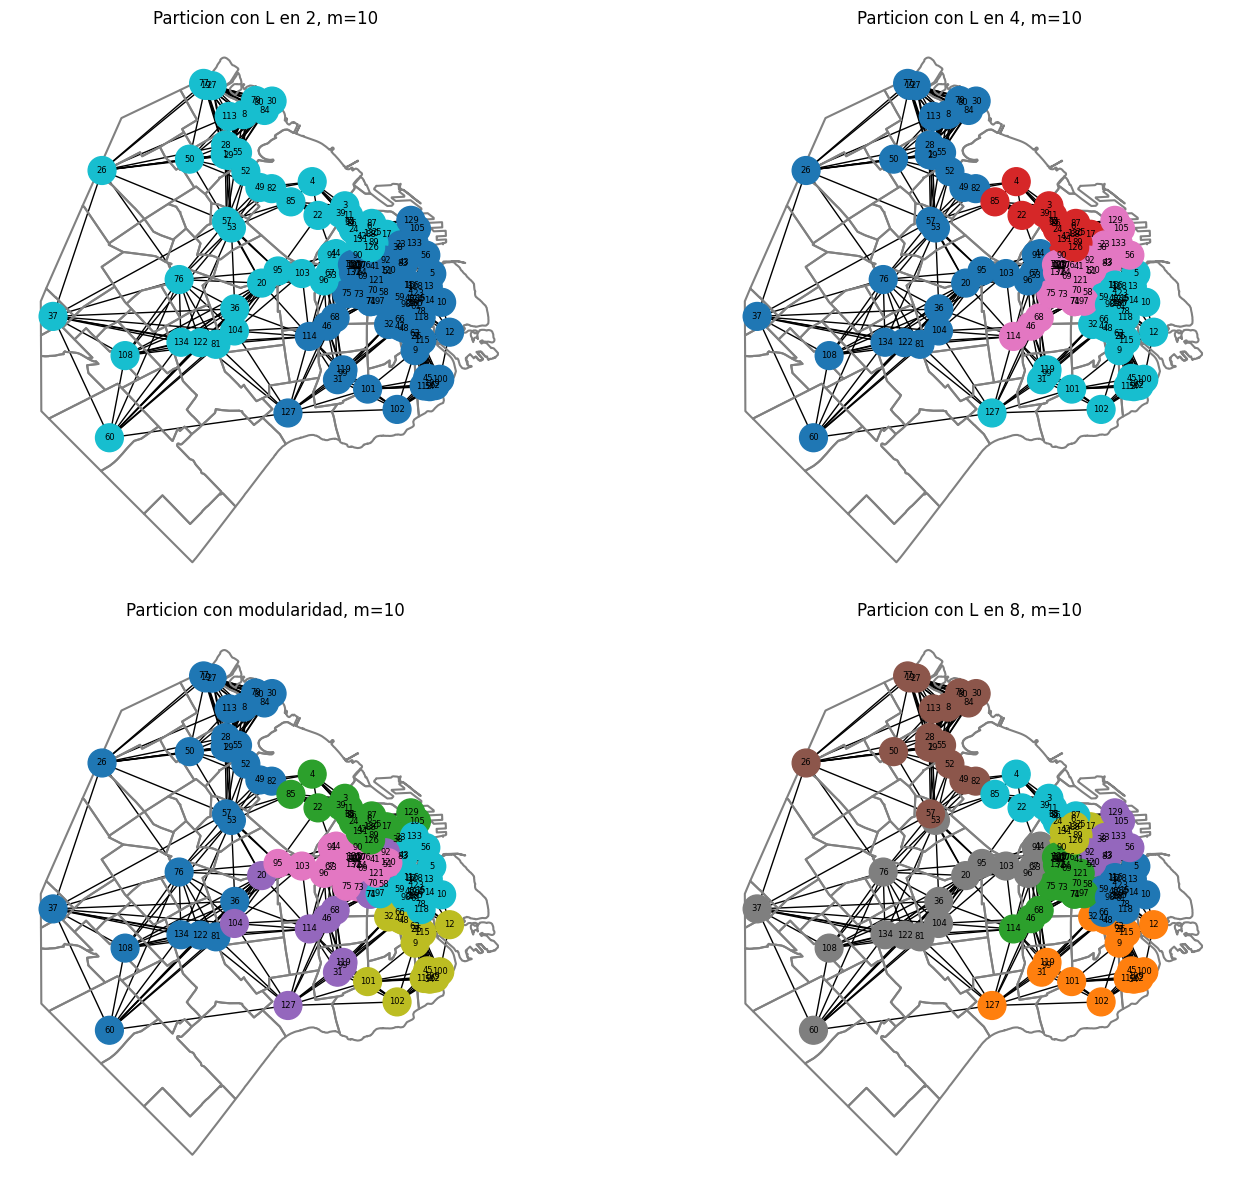

In [ ]:
particiones = [
    (particionL_10_en2, "Particion con L en 2, m=10"),
    (particionL_10_en4, "Particion con L en 4, m=10"),
    (particionM_10, "Particion con modularidad, m=10"),
    (particionL_10_en8, "Particion con L en 8, m=10")
]
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs = axs.flatten()

for i, (particion, titulo) in enumerate(particiones):
    grafo_particion(A10s, particion, titulo, G_layout, barrios, ax=axs[i])

for j in range(len(particiones), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

Seguimos viendo consistencia en los resultados obtenidos a partir del laplaciano, sigue manteniendo una partición sin aspectos a destacar. Cambia levemente la agrupación geográfica de los nodos, pero nuevamente, nada radical. Lo que si podemos notar, es que con una m duplicada respecto de la ultima que vimos ahora obtuvimos una partición en grupos más concentrados geograficamente. El grupo en turquesa es el único que incumple esto último, pero el resto sí están en zonas diferenciables facilmente.

Ahora pasemos a ver la comparación más directa posible entre particiones dadas por la modularidad y el laplaciano, que se pueden ver en los ultimos 2 grafos. Ya con un m más grande como es 10, la cercania geográfica entre nodos de un mismo grupo es mayor en las particiones dadas por la modularidad. A diferencia de la partición del laplaciano vemos que la de la modularidad nos dividio todo el oeste como un grupo y el resto de los grupos quedaron en el este. Esta dispersión no se ve (por lo menos hasta ahora) en las particiones dadas por el método del laplaciano. Cabe destacar que la partición dada por el laplaciano en 4 también divide al oeste de todo el resto, lo cual tiene sentido ya que es la zona menos densamente poblada por nodos mientras que en el este está la mayor concentración de nodos.

Repetimos el proceso una vez más para m=50.

In [58]:
A50 = construye_adyacencia(D, 50)
A50s = simetrizar(A50)
cantidad_de_aristas = calcula_cant_aristas(A50s)
particionL_50_en2 = laplaciano_iterativo(A50s, 1)
particionL_50_en4 = laplaciano_iterativo(A50s, 2)

Ya en el último caso vemos que pasa cuando dividimos en 2 y 4:

In [59]:
mostrar_particion(particionL_50_en2)

| Grupo   | Nodos                                                                                                                                                                                                                                                                                            |
|:--------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 1, 3, 4, 6, 7, 8, 11, 17, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 33, 34, 36, 37, 39, 42, 44, 49, 50, 52, 53, 55, 57, 60, 65, 67, 72, 75, 76, 77, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 103, 104, 106, 108, 110, 111, 113, 117, 122, 125, 126, 129, 130, 131, 132, 134 |
| Grupo 2 | 0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 23, 31, 32, 35, 38, 40, 41, 43, 45,

In [60]:
mostrar_particion(particionL_50_en4)

| Grupo   | Nodos                                                                                                                                                 |
|:--------|:------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 0, 9, 21, 31, 32, 35, 45, 46, 47, 48, 54, 62, 63, 66, 68, 70, 71, 73, 74, 97, 98, 99, 100, 101, 102, 109, 112, 114, 115, 118, 119, 127                |
| Grupo 2 | 2, 5, 10, 12, 13, 14, 15, 16, 18, 23, 38, 40, 41, 43, 51, 56, 58, 59, 61, 64, 69, 78, 83, 92, 105, 107, 116, 120, 121, 123, 124, 128, 133, 135        |
| Grupo 3 | 1, 20, 22, 26, 29, 33, 36, 37, 44, 49, 50, 52, 53, 57, 60, 67, 75, 76, 81, 82, 85, 91, 94, 95, 96, 103, 104, 108, 110, 111, 122, 132, 134             |
| Grupo 4 | 3, 4, 6, 7, 8, 11, 17, 19, 24, 25, 27, 28, 30, 34, 39, 42, 55, 65, 72, 77, 79, 80, 84, 86, 87, 88, 89, 90, 93, 106, 113, 117, 125, 126, 129, 130, 131 |


Por último, veamos que sucede con la modularización para D con m=50

In [61]:
R50 = calcula_R(A50s)
particionM_50 = modularidad_iterativo(A50s, R50)

Y ahora con la modularidad: 

In [62]:
mostrar_particion(particionM_50)

| Grupo   | Nodos                                                                                                                                                                                                                                                                                        |
|:--------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Grupo 1 | 0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 23, 31, 32, 35, 38, 40, 41, 43, 45, 46, 47, 48, 51, 54, 56, 58, 59, 61, 62, 63, 64, 66, 68, 69, 70, 71, 73, 74, 75, 78, 83, 92, 97, 98, 99, 100, 101, 102, 105, 107, 109, 112, 114, 115, 116, 118, 119, 120, 121, 123, 124, 127, 128, 133, 135   |
| Grupo 2 | 1, 3, 4, 6, 7, 8, 11, 17, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 33, 34, 36, 37, 39, 42, 4

Por último, veamos los grafos en este caso:

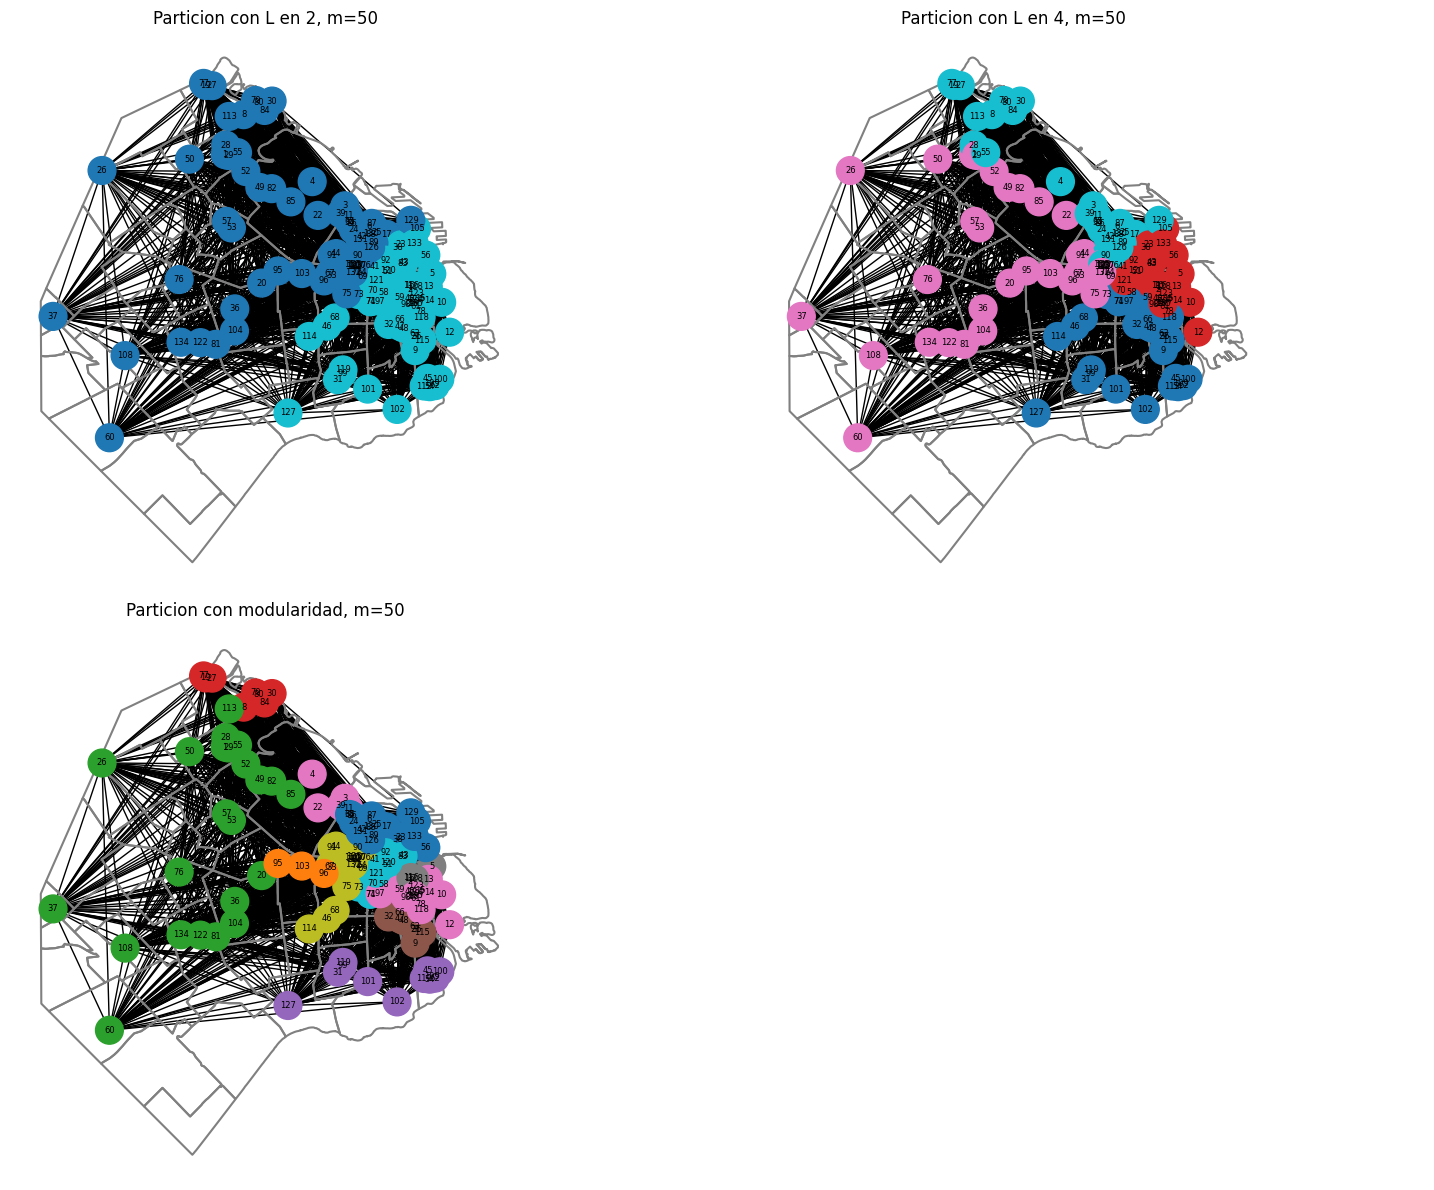

In [ ]:
particiones = [
    (particionL_50_en2, "Particion con L en 2, m=50"),
    (particionL_50_en4, "Particion con L en 4, m=50"),
    (particionM_3, "Particion con modularidad, m=50")
]
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs = axs.flatten()

for i, (particion, titulo) in enumerate(particiones):
    grafo_particion(A50s, particion, titulo, G_layout, barrios, ax=axs[i])

for j in range(len(particiones), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

Para este m cinco veces más grande que el anterior vemos que las diferencias entre la partición dada por el laplaciano en 2 grupos y la dada por la modularidad son nulas, pues son la misma partición. Sucede algo similar a lo visto en la red de ejemplo, que las particiones coincidian completamente. Nuevamente, la partición en 4 dada por el laplaciano no tiene nada remarcable.

Viendo estos distintos casos podemos ver que a más conexiones (m) vemos que la cantidad de grupos dada por el metodo de modularidad iterativo es menor y se acerca cada vez más a la del laplaciano con un solo nivel, es decir, con una partición en dos grupos. En particular, para m=50, las particiones dadas por la modularidad y el laplaciano con un nivel es exactamente la misma. 

También observamos que para redes con pocas conexiones las particiones dadas por la modularidad son poco intuitivas porque divide en grupos en los que los nodos de un mismo grupo no quedan siempre geográficamente cerca. La división intuitiva sería en la que los nodos de un mismo grupo se encuentran cerca entre sí. Y el método que coincidió siempre con esa división fue el laplaciano. Por lo dicho antes, si el grafo tiene un nivel intermedio de conexiones (m=10 por ejemplo) tendremos un resultado más intuitivo que para m chicos. Más aun, cuando hay gran densidad de nodos y pocas conexiones (m bajo, como 3 o 5) el metodo de modularidad es cuando resultados menos intuitivos da.

## Punto 5

A lo largo de los dos trabajos prácticos hemos explorado la red de museos de la Ciudad Autónoma de Buenos Aires desde una perspectiva computacional, geográfica y algebraica. Esta experiencia nos permitió integrar métodos cuantitativos, visualización de datos, y conceptos fundamentales de álgebra lineal para analizar estructuras de red y patrones espaciales.

En el primer trabajo práctico, comenzamos por construir la red de museos a partir de datos públicos disponibles. A partir de las coordenadas geográficas de los museos y su distribución en los barrios de CABA, generamos una matriz de adyacencia basada en cercanía geográfica, formulando un sistema de ecuaciones lineales que define un vector de importancia o ranking para cada museo. Utilizamos el modelo de Pagerank con amortiguación (al parámetro lo llamamos α), y se nos pidió demostrar que dicho ranking podía expresarse como la solución de un sistema lineal del tipo Mp=1. Esta formulación nos permitió aplicar nociones como matrices estocásticas, autovalores, vectores propios, y resolvimos el sistema empleando herramientas numéricas.

En el segundo trabajo práctico, nos enfocamos en el análisis espectral de la red utilizando los autovalores y autovectores de la matriz Laplaciana y el método de modularidad. Descubrimos cómo el segundo autovalor más pequeño y su autovector correspondiente pueden utilizarse para detectar comunidades o cuellos de botella en la red. Esto permitió identificar subgrupos de museos que están más densamente conectados entre sí, revelando una estructura interna significativa en la red. Resultó especialmente interesante observar cómo ciertos museos funcionan como “puentes” entre diferentes regiones o temáticas, revelando su rol estratégico en la difusión cultural.

La combinación de ambas etapas evidenció cómo el análisis computacional y los modelos de red pueden ser herramientas potentes para políticas públicas culturales. Por ejemplo, identificar nodos aislados puede sugerir oportunidades de integración o colaboración, mientras que visualizar la densidad de conexiones permite comprender mejor la distribución de recursos o contenidos. Además, vimos como expresar conceptos intuitivos como las divisiones geográficas en una red. También, las estrategias de clustering implementadas nos ayudaron a ver cuán importante es la cantidad de conexiones en una red, como hace que la distribución sea más uniforme y justamente, haga que no esté tan presente la noción de nodos aislados. Vimos como en redes con una gran cantidad de conexiones las particiones dadas nos llevaron a esta última idea, en la que ya no juega un rol central la disposición geográfica y de esta manera ayudando a una comunidad de museos más unida y por tanto, más rica culturalmente. 

En síntesis, los TPs nos permitieron conectar el análisis territorial con el cálculo matricial, mostrando cómo herramientas teóricas se traducen en análisis concretos de redes urbanas. Esta integración de datos, teoría y visualización nos resulta especialmente valiosa para abordar múltiples problemas en ciencia de datos, urbanismo y políticas públicas, así dandonos una forma de "traer a tierra" lo visto durante el cuatrimestre.